In [1]:
import pandas as pd
import scipy
import numpy as np
import re
import time
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from surprise import SVD
from surprise import Dataset
from surprise import KNNWithMeans, Reader, Dataset
from surprise.model_selection import GridSearchCV

# COLLAB FILTERING USING KNN

In [2]:
# Load MovieLens data
ratings = pd.read_csv(r'ratings.csv')
movies = pd.read_csv(r'movies.csv')

# Join movies w/ their ratings
ratings = pd.merge(movies, ratings)

# Fill NA with 0
ratings['rating'] = ratings['rating'].fillna('0')

# Select only relevant fields
ratings_filtered = ratings[['userId', 'title', 'rating']]

ratings_filtered.head()

,userId,title,rating
0,1,Toy Story (1995),4.0
1,5,Toy Story (1995),4.0
2,7,Toy Story (1995),4.5
3,15,Toy Story (1995),2.5
4,17,Toy Story (1995),4.5


In [3]:
reader = Reader(rating_scale=(0, 5), line_format = 'user item rating')
gs_data = Dataset.load_from_df(ratings_filtered, reader)

In [4]:
# # Only run to optimize params again!

# Params to optimize
sim_options = {
    "name": ["cosine", "pearson"],
    "min_support": [1, 2, 3],
    "user_based": [False, True]
}
#10, 20, 30
param_grid = {
    "k": [10, 20, 30],
    "min_k": [1, 2, 3],
    "sim_options": sim_options
}

# Run GridSearch to find best params w/ highest rmse
gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=10)
start = time.time()
gs_res = gs.fit(gs_data)
end = time.time()
print ("Time elapsed:", end - start)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Time elapsed: 10235.2117395401


In [5]:
# # Only after optimizing params!
print(gs.best_params["rmse"])
print('rmse:', gs.best_score["rmse"])

{'k': 30, 'min_k': 3, 'sim_options': {'name': 'pearson', 'min_support': 3, 'user_based': True}}
rmse: 0.8837312698533457


In [6]:
# To use parms from GridSearchCV
sim_options = {
    "name": "pearson",
    "min_support": 3,
    "user_based": True
}

algo = KNNWithMeans(sim_options=sim_options, k=30, min_k=3)
predictions = algo.fit(gs_data.build_full_trainset())

pred_movies = []
for title in ratings['title']:
    pred = algo.predict(1, title)
    pred_movies.append(pred)

pred_analysis = pd.DataFrame(pred_movies).sort_values('est', ascending=False)[['iid', 'est']]
pred_analysis.drop_duplicates(subset=["iid"]).head(50)

Computing the pearson similarity matrix...
Done computing similarity matrix.


,iid,est
26143,Goodfellas (1990),5.0
25145,Raiders of the Lost Ark (Indiana Jones and the...,5.0
86839,Funny Games U.S. (2007),5.0
25236,Brazil (1985),5.0
25383,"Good, the Bad and the Ugly, The (Buono, il bru...",5.0
24995,"Princess Bride, The (1987)",5.0
86336,Futurama: Bender's Big Score (2007),5.0
86507,There Will Be Blood (2007),5.0
24208,Wallace & Gromit: The Wrong Trousers (1993),5.0
25754,Apocalypse Now (1979),5.0


In [7]:
# Use default params
sim_options = {
    "name": "pearson",
    "min_support": 1,
    "user_based": True
}

algo = KNNWithMeans(sim_options=sim_options)
predictions = algo.fit(gs_data.build_full_trainset())

pred_movies = []
for title in ratings['title']:
    pred = algo.predict(1, title)
    pred_movies.append(pred)

pred_analysis = pd.DataFrame(pred_movies).sort_values('est', ascending=False)[['iid', 'est']]
pred_analysis.drop_duplicates(subset=["iid"]).head(50)

Computing the pearson similarity matrix...
Done computing similarity matrix.


,iid,est
27062,Annie Hall (1977),5.0
25807,Apocalypse Now (1979),5.0
25597,"Clockwork Orange, A (1971)",5.0
78534,"Facing Windows (Finestra di fronte, La) (2003)",5.0
78516,Last Life in the Universe (Ruang rak noi nid m...,5.0
78661,Slasher (2004),5.0
78722,DiG! (2004),5.0
78718,Born into Brothels (2004),5.0
78711,Tae Guk Gi: The Brotherhood of War (Taegukgi h...,5.0
78507,"Green Butchers, The (Grønne slagtere, De) (2003)",5.0


In [8]:
# Get movie rec with a small pool of movie ratings
def get_rec_knn(movies):
    x = ratings_filtered.copy()

    for m in movies:
        x = x.append(pd.DataFrame([[9999, m[0], m[1]]], 
                                  columns=['userId', 'title', 'rating']), 
                     ignore_index=True)
    
    # To use parms from GridSearchCV
    sim_options = {
        "name": "pearson",
        "min_support": 1, # Changed 3 to 1 to account for small pool of movie ratings
        "user_based": False # With a small pool of ratings, item based is better
    }
    
    gs_data = Dataset.load_from_df(x, reader)

    algo = KNNWithMeans(sim_options=sim_options)
    predictions = algo.fit(gs_data.build_full_trainset())

    pred_movies = []
    for title in ratings['title']:
        if title in list(map(lambda n: n[0], movies)):
            continue
        pred = algo.predict(9999, title)
        pred_movies.append(pred)

    pred_analysis = pd.DataFrame(pred_movies).sort_values('est', ascending=False)[['iid', 'est']]
    display(pred_analysis.drop_duplicates(subset=["iid"]).head(50))

In [9]:
get_rec_knn([("Inception (2010)", 5), ("Avengers: Infinity War - Part I (2018)", 4), ("Lion King, The (1994)", 4), ("A Quiet Place (2018)", 4), ("Avatar (2009)", 5)])

C:\Users\eric2\AppData\Local\Temp\ipykernel_20232\526593372.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x = x.append(pd.DataFrame([[9999, m[0], m[1]]],
C:\Users\eric2\AppData\Local\Temp\ipykernel_20232\526593372.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x = x.append(pd.DataFrame([[9999, m[0], m[1]]],
C:\Users\eric2\AppData\Local\Temp\ipykernel_20232\526593372.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x = x.append(pd.DataFrame([[9999, m[0], m[1]]],
C:\Users\eric2\AppData\Local\Temp\ipykernel_20232\526593372.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x = x.append(pd.DataFrame([[9999, m[0], m[1]]],
C:\U

Computing the pearson similarity matrix...
Done computing similarity matrix.


,iid,est
20621,Roman Holiday (1953),5.0
27643,8 1/2 (8½) (1963),5.0
95022,Maniac Cop 2 (1990),5.0
61969,Dr. Goldfoot and the Bikini Machine (1965),5.0
39816,1984 (Nineteen Eighty-Four) (1984),5.0
95124,Justice League: Doom (2012),5.0
95176,Bill Hicks: Revelations (1993),5.0
27644,Chinatown (1974),5.0
95012,Escape from Planet Earth (2013),5.0
94984,Side Effects (2013),5.0


# USER-ITEM Collaborative Filtering Recommendation System USING SIMILARITY SEARCH

Preprocessing of netflix and movielen datasets (With their own respective users' ratings)

In [10]:
ratings = pd.read_csv("userDatas.csv")
netflixData = pd.read_csv("netflix_titles.csv")
ratings = ratings.merge(netflixData)

movieLen = pd.read_csv("movies.csv")
mRatings = pd.read_csv("ratings.csv")
mRatings = mRatings.merge(movieLen)
mRatings

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
100831,610,160341,2.5,1479545749,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,1493844794,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,1493848789,Blair Witch (2016),Horror|Thriller


In [11]:
ratings['cast'] = ratings['cast'].fillna(' ')
ratings['fav_cast'] = ratings['fav_cast'].fillna(' ')
ratings['director'] = ratings['director'].fillna(' ')
ratings['country'] = ratings['country'].fillna(' ')

ratings.head(61)

,user_id,fav_genre,show_id,fav_cast,user_rating,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,u1,"Action & Adventure,Scifi & Fantasy",s144,"Tobey Maguire,James Franco",3,Movie,Green Lantern,Martin Campbell,"Ryan Reynolds, Blake Lively, Peter Sarsgaard, ...",United States,"September 1, 2021",2011,PG-13,114 min,"Action & Adventure, Sci-Fi & Fantasy",Test pilot Hal Jordan harnesses glowing new po...
1,u1,"Action & Adventure,Scifi & Fantasy",s6201,"Tobey Maguire,James Franco",5,Movie,Avengers: Infinity War,"Anthony Russo, Joe Russo","Robert Downey Jr., Josh Brolin, Mark Ruffalo, ...",United States,"December 25, 2018",2018,PG-13,150 min,"Action & Adventure, Sci-Fi & Fantasy",Superheroes amass to stop intergalactic sociop...
2,u3,Action & Adventure,s6201,"Chris Hemsworth,Rain,Matt Damon,Jason Statham,...",5,Movie,Avengers: Infinity War,"Anthony Russo, Joe Russo","Robert Downey Jr., Josh Brolin, Mark Ruffalo, ...",United States,"December 25, 2018",2018,PG-13,150 min,"Action & Adventure, Sci-Fi & Fantasy",Superheroes amass to stop intergalactic sociop...
3,u1,"Action & Adventure,Scifi & Fantasy",s8068,"Tobey Maguire,James Franco",4,Movie,Spider-Man 3,Sam Raimi,"Tobey Maguire, Kirsten Dunst, James Franco, Th...",United States,"November 1, 2019",2007,PG-13,139 min,"Action & Adventure, Sci-Fi & Fantasy",The seemingly invincible Spider-Man goes up ag...
4,u1,"Action & Adventure,Scifi & Fantasy",s8069,"Tobey Maguire,James Franco",5,Movie,Spider-Man: Into the Spider-Verse,"Peter Ramsey, Rodney Rothman, Bob Persichetti","Shameik Moore, Jake Johnson, Hailee Steinfeld,...",United States,"June 26, 2019",2018,PG,117 min,"Action & Adventure, Comedies","After being bitten by a radioactive spider, Br..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,u10,Dramas,s113,"Naomi Watts,Miachel Keaton,Zaria,Amy Ryan",5,Movie,Worth,Sara Colangelo,"Michael Keaton, Stanley Tucci, Amy Ryan, Shuno...",,"September 3, 2021",2021,PG-13,119 min,Dramas,"In the wake of the Sept. 11 attacks, a lawyer ..."
57,u10,Dramas,s1090,"Naomi Watts,Miachel Keaton,Zaria,Amy Ryan",3,Movie,Two Distant Strangers,"Travon Free, Martin Desmond Roe","Joey Bada$$, Andrew Howard, Zaria",United States,"April 9, 2021",2021,TV-MA,32 min,Dramas,"In this Oscar-nominated short film, a man tryi..."
58,u10,Dramas,s1485,"Naomi Watts,Miachel Keaton,Zaria,Amy Ryan",2,Movie,Cops and Robbers,"Arnon Manor, Timothy Ware-Hill",Timothy Ware-Hill,United States,"December 28, 2020",2020,PG-13,8 min,Dramas,Animation and activism unite in this multimedi...
59,u10,Dramas,s1436,"Naomi Watts,Miachel Keaton,Zaria,Amy Ryan",5,Movie,Pieces of a Woman,Kornél Mundruczó,"Vanessa Kirby, Shia LaBeouf, Ellen Burstyn, Mo...","Canada, Hungary, United States","January 7, 2021",2020,R,128 min,Dramas,A heartbreaking home birth leaves a woman grap...


In [12]:
mRatings = mRatings[['userId', 'movieId', 'rating', 'title', 'genres']]
mRatings

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...
100831,610,160341,2.5,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,Blair Witch (2016),Horror|Thriller


#### Create a table that shows user's rating of different show/movie titles

Netflix User ratings

In [13]:
userRatings = ratings.pivot_table(index=['user_id'],columns=['title'],values='user_rating')
print("Before: ",userRatings.shape)
userRatings.fillna(0, inplace=True)
print("After: ",userRatings.shape)
userRatings.head(10)

Before:  (10, 58)
After:  (10, 58)


title,60 Days In,Akame ga Kill!,Attack on Titan,Avengers: Infinity War,Blade Runner: The Final Cut,Bling Empire,"Bob Ross: Happy Accidents, Betrayal & Greed",Cops and Robbers,Cosmic Sin,Creating an Army of the Dead,...,The Kissing Booth 3,The Secret Life of Pets 2,The Seven Deadly Sins,The Seventh Day,The Show Must Go On: The Queen + Adam Lambert Story,Tinker Bell and the Legend of the NeverBeast,Truth or Dare,Two Distant Strangers,Why Did You Kill Me?,Worth
user_id,,,,,,,,,,,,,,,,,,,,,
u1,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0
u2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
u3,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u4,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u5,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
u6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0
u7,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u8,2.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


MovieLen User Ratings

In [14]:
userMRatings = mRatings.pivot_table(index=['userId'], columns=['title'], values='rating')
userMRatings.fillna(0, inplace=True)
userMRatings.head(10)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Movie/show Correlation data using pearson correlations

### Netflix data Correlation

In [15]:
corrMatrix = userRatings.corr(method='pearson')
corrMatrix.head(10)

title,60 Days In,Akame ga Kill!,Attack on Titan,Avengers: Infinity War,Blade Runner: The Final Cut,Bling Empire,"Bob Ross: Happy Accidents, Betrayal & Greed",Cops and Robbers,Cosmic Sin,Creating an Army of the Dead,...,The Kissing Booth 3,The Secret Life of Pets 2,The Seven Deadly Sins,The Seventh Day,The Show Must Go On: The Queen + Adam Lambert Story,Tinker Bell and the Legend of the NeverBeast,Truth or Dare,Two Distant Strangers,Why Did You Kill Me?,Worth
title,,,,,,,,,,,,,,,,,,,,,
60 Days In,1.000000,-0.111111,-0.111111,-0.166667,-0.111111,1.000000,-0.111111,-0.111111,-0.111111,-0.111111,...,-0.111111,-0.111111,-0.111111,-0.111111,1.000000,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111
Akame ga Kill!,-0.111111,1.000000,1.000000,-0.166667,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,...,-0.111111,-0.111111,1.000000,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111
Attack on Titan,-0.111111,1.000000,1.000000,-0.166667,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,...,-0.111111,-0.111111,1.000000,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111
Avengers: Infinity War,-0.166667,-0.166667,-0.166667,1.000000,-0.166667,-0.166667,-0.166667,-0.166667,0.666667,-0.166667,...,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667
Blade Runner: The Final Cut,-0.111111,-0.111111,-0.111111,-0.166667,1.000000,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,...,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111
Bling Empire,1.000000,-0.111111,-0.111111,-0.166667,-0.111111,1.000000,-0.111111,-0.111111,-0.111111,-0.111111,...,-0.111111,-0.111111,-0.111111,-0.111111,1.000000,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111
"Bob Ross: Happy Accidents, Betrayal & Greed",-0.111111,-0.111111,-0.111111,-0.166667,-0.111111,-0.111111,1.000000,-0.111111,-0.111111,1.000000,...,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,1.000000,-0.111111
Cops and Robbers,-0.111111,-0.111111,-0.111111,-0.166667,-0.111111,-0.111111,-0.111111,1.000000,-0.111111,-0.111111,...,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,1.000000,-0.111111,1.000000
Cosmic Sin,-0.111111,-0.111111,-0.111111,0.666667,-0.111111,-0.111111,-0.111111,-0.111111,1.000000,-0.111111,...,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111


Netflix Pearson Correlation HeatMap

<AxesSubplot: xlabel='title', ylabel='title'>

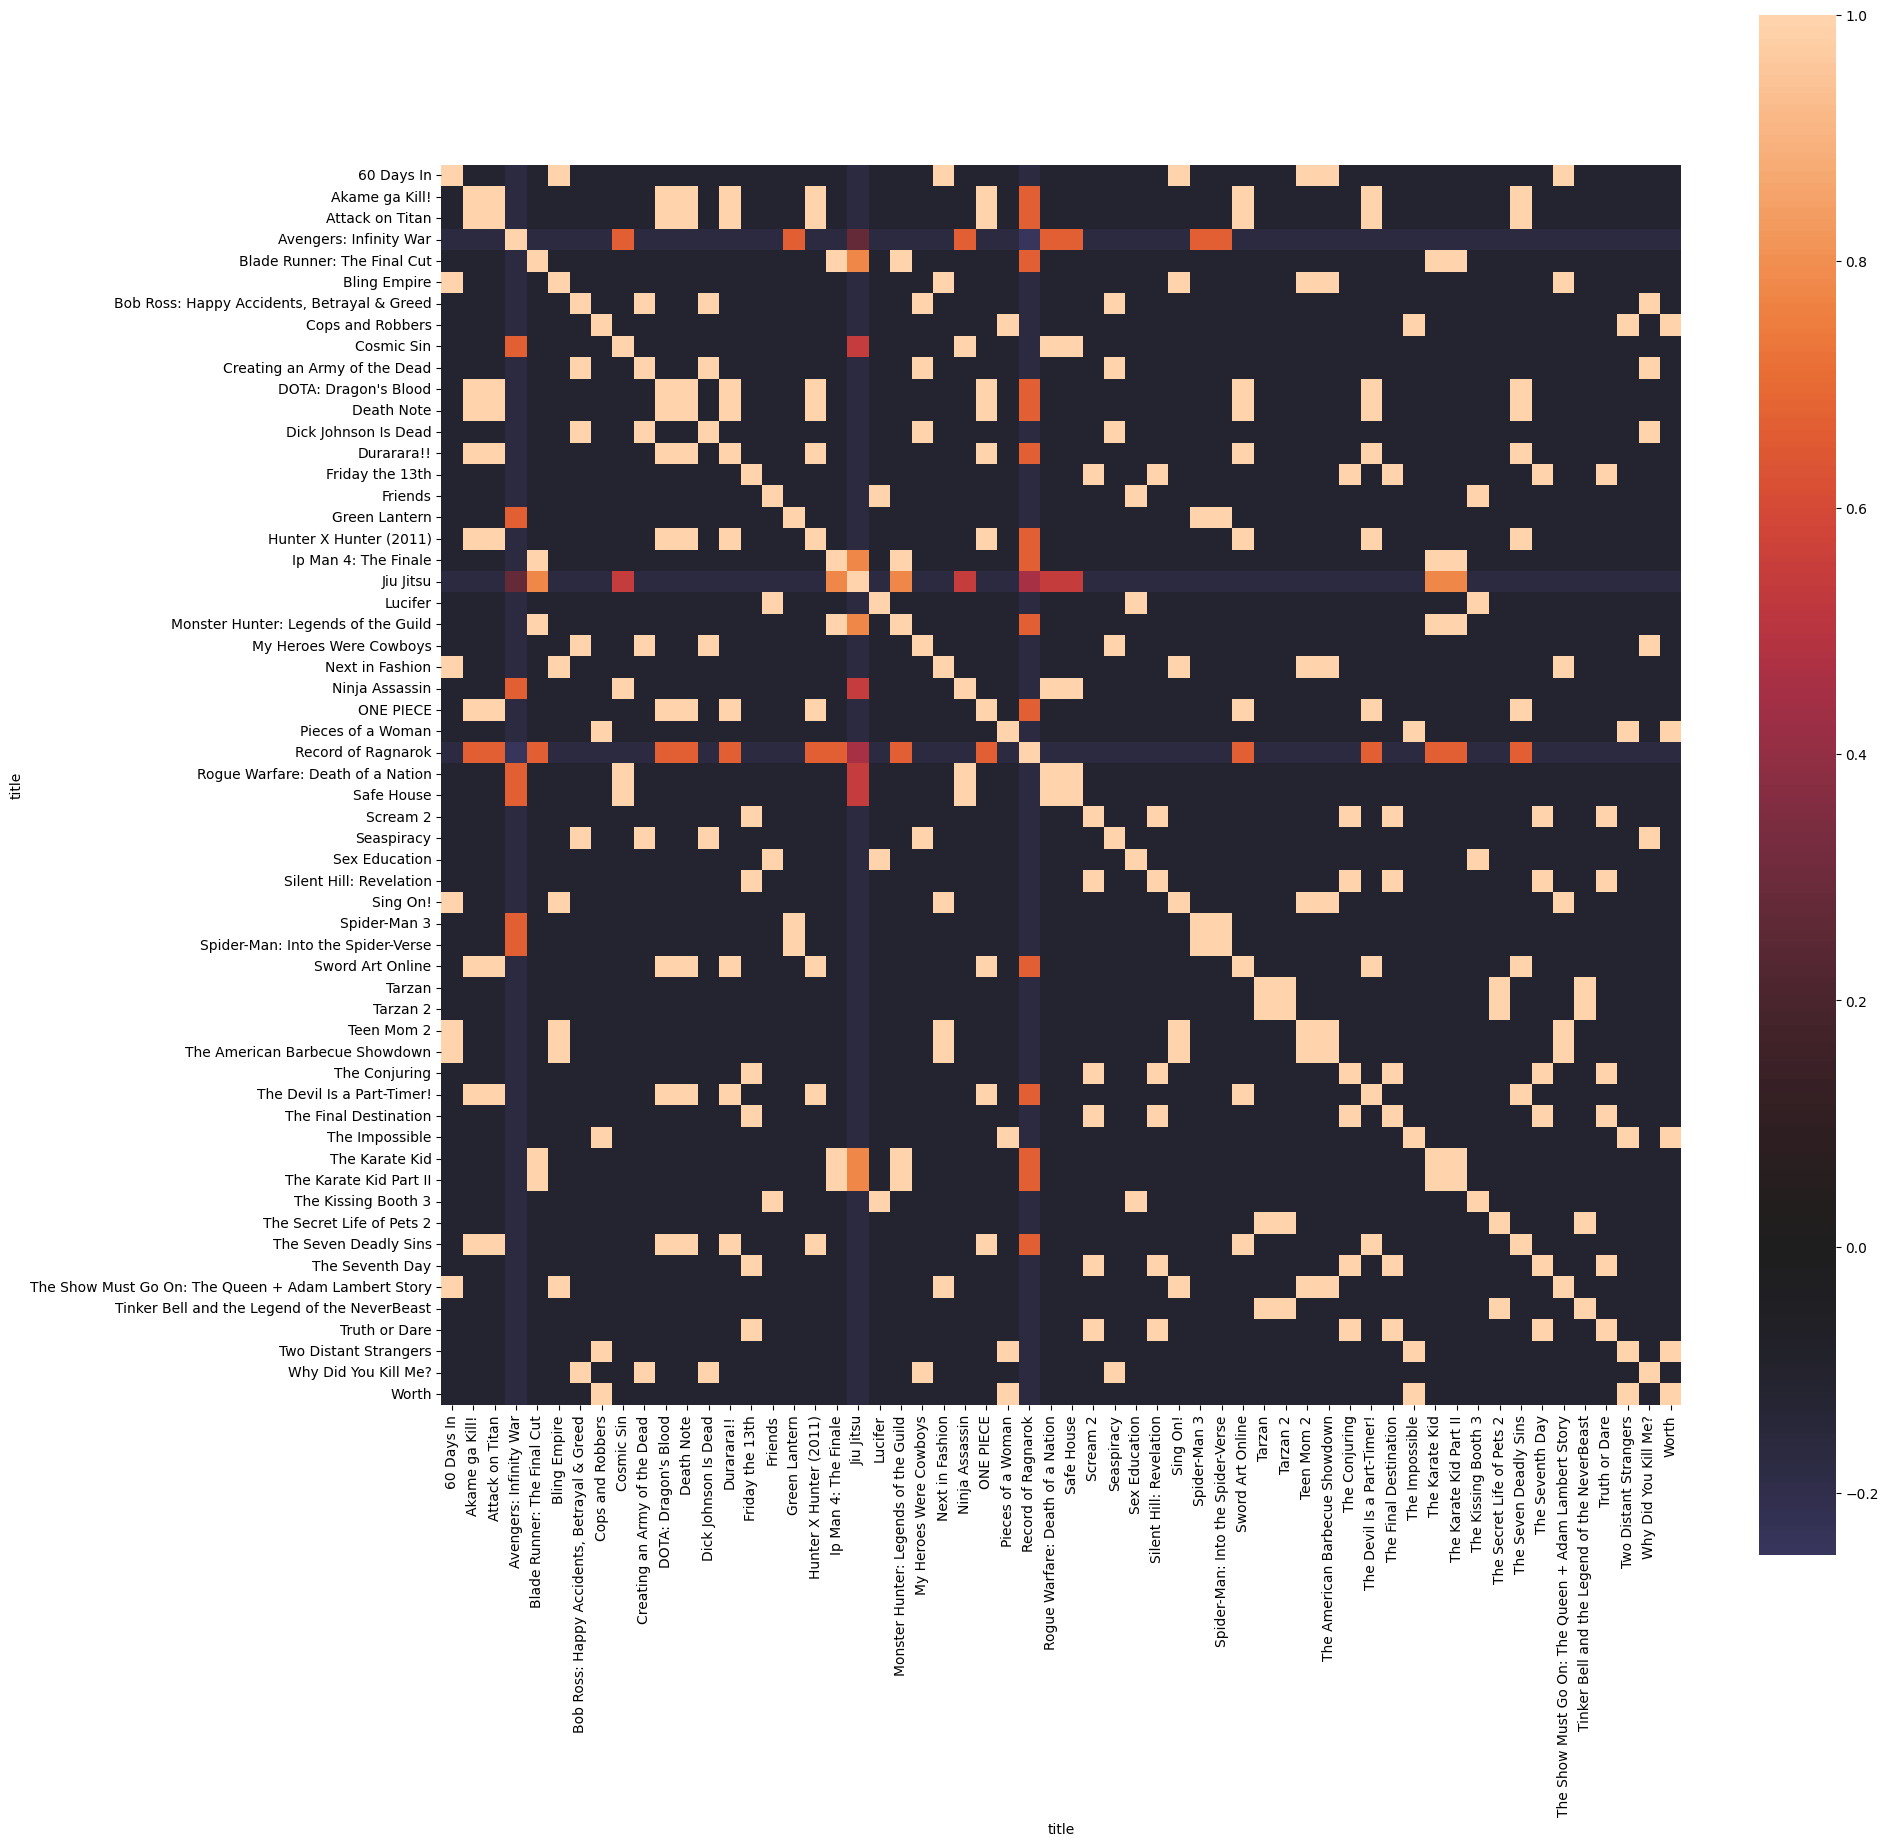

In [ ]:
f, ax  =plt.subplots(figsize = (20,20))
sns.heatmap(corrMatrix, square = True, center = 0, annot = False)

### MovieLen data correlation

In [16]:
corrMMatrix = userMRatings.corr(method='pearson')
corrMMatrix.head(10)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.000000,-0.001642,-0.002324,-0.001642,-0.002254,-0.001642,-0.006407,-0.001642,0.135943,-0.004325,...,-0.001642,0.339935,0.542247,0.706526,-0.001642,-0.007675,0.134327,0.325287,-0.008185,-0.001642
'Hellboy': The Seeds of Creation (2004),-0.001642,1.000000,0.706526,-0.001642,-0.002254,-0.001642,-0.006407,-0.001642,-0.010568,-0.004325,...,-0.001642,-0.004589,-0.002808,-0.002324,-0.001642,-0.007675,-0.007744,-0.003594,-0.008185,-0.001642
'Round Midnight (1986),-0.002324,0.706526,1.000000,-0.002324,-0.003191,-0.002324,0.170199,-0.002324,-0.014958,-0.006121,...,-0.002324,-0.006495,-0.003975,-0.003289,-0.002324,-0.010863,-0.010961,-0.005087,-0.011585,-0.002324
'Salem's Lot (2004),-0.001642,-0.001642,-0.002324,1.000000,0.857269,-0.001642,-0.006407,-0.001642,-0.010568,-0.004325,...,-0.001642,-0.004589,-0.002808,-0.002324,-0.001642,-0.007675,-0.007744,-0.003594,-0.008185,-0.001642
'Til There Was You (1997),-0.002254,-0.002254,-0.003191,0.857269,1.000000,-0.002254,-0.008797,-0.002254,-0.014510,-0.005938,...,-0.002254,-0.006301,-0.003856,-0.003191,-0.002254,-0.010538,-0.010632,-0.004935,-0.011238,-0.002254
'Tis the Season for Love (2015),-0.001642,-0.001642,-0.002324,-0.001642,-0.002254,1.000000,-0.006407,-0.001642,-0.010568,-0.004325,...,-0.001642,-0.004589,-0.002808,-0.002324,-0.001642,-0.007675,-0.007744,-0.003594,-0.008185,-0.001642
"'burbs, The (1989)",-0.006407,-0.006407,0.170199,-0.006407,-0.008797,-0.006407,1.000000,0.065968,0.063117,0.235908,...,-0.006407,-0.017905,-0.010957,-0.009068,-0.006407,0.187953,0.062174,-0.014025,0.353194,-0.006407
'night Mother (1986),-0.001642,-0.001642,-0.002324,-0.001642,-0.002254,-0.001642,0.065968,1.000000,-0.010568,-0.004325,...,-0.001642,-0.004589,-0.002808,-0.002324,-0.001642,0.212646,-0.007744,-0.003594,0.175610,-0.001642
(500) Days of Summer (2009),0.135943,-0.010568,-0.014958,-0.010568,-0.014510,-0.010568,0.063117,-0.010568,1.000000,0.133949,...,0.094083,0.126147,0.061652,0.088726,-0.010568,0.053614,0.241092,0.139511,0.125905,-0.010568


In [17]:
newCorrMMatrix = corrMMatrix.iloc[0:75,0:75]


Due to the large size in the data, sample size of 75 movies were taken to display the correlation on the heatmap

<AxesSubplot: xlabel='title', ylabel='title'>

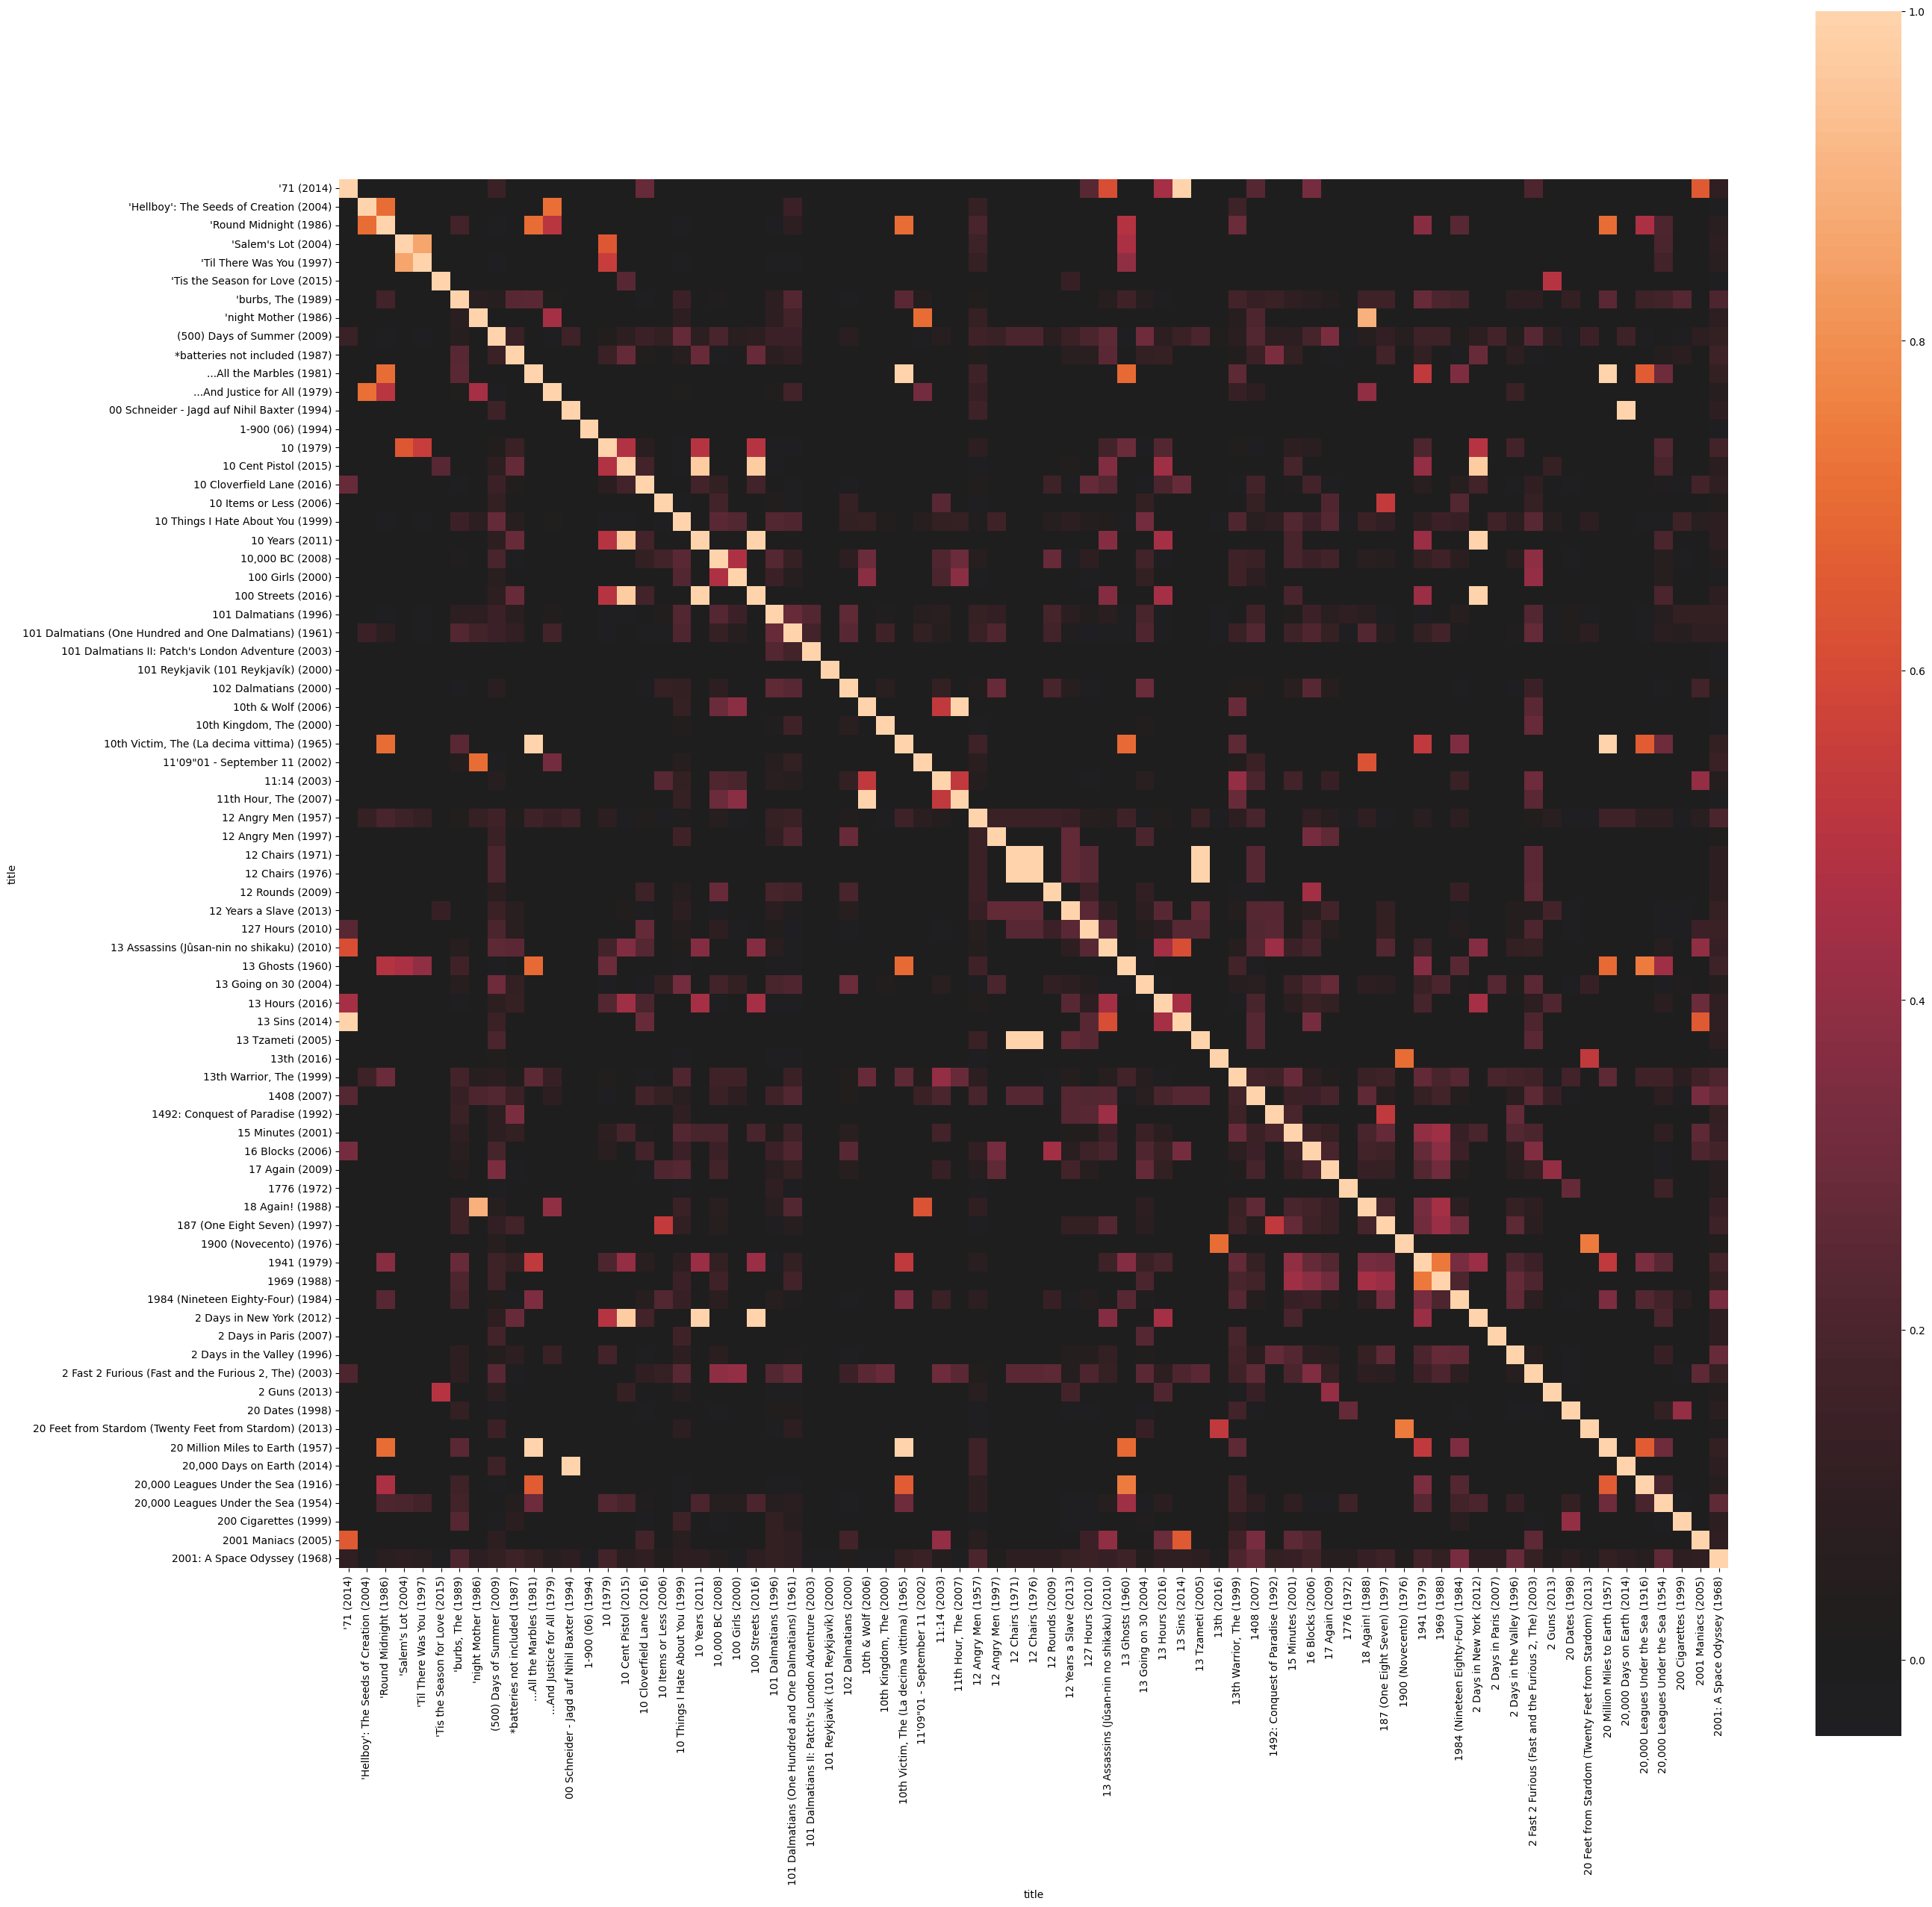

In [18]:
f, ax  =plt.subplots(figsize = (30,30))
sns.heatmap(newCorrMMatrix, square = True, center = 0, annot = False)

## Standardisation function for pearson correlation

In [19]:
def standardize(row):
    new_row = (row - row.mean())/(row.max()-row.min())
    return new_row

## Cosine Similarity Metric Evaluation

Netflix Data

In [20]:
df_temp = userRatings
df_std = df_temp.apply(standardize)

user_similarity = cosine_similarity(df_std.T)
user_similarity

array([[ 1.        , -0.11111111, -0.11111111, ..., -0.11111111,
        -0.11111111, -0.11111111],
       [-0.11111111,  1.        ,  1.        , ..., -0.11111111,
        -0.11111111, -0.11111111],
       [-0.11111111,  1.        ,  1.        , ..., -0.11111111,
        -0.11111111, -0.11111111],
       ...,
       [-0.11111111, -0.11111111, -0.11111111, ...,  1.        ,
        -0.11111111,  1.        ],
       [-0.11111111, -0.11111111, -0.11111111, ..., -0.11111111,
         1.        , -0.11111111],
       [-0.11111111, -0.11111111, -0.11111111, ...,  1.        ,
        -0.11111111,  1.        ]])

MovieLen Data

In [21]:
df_tempM = userMRatings
df_stdM = df_tempM.apply(standardize)

user_Msimilarity = cosine_similarity(df_stdM.T)
user_Msimilarity

array([[ 1.        , -0.00164204, -0.0023241 , ...,  0.32528734,
        -0.00818543, -0.00164204],
       [-0.00164204,  1.        ,  0.706526  , ..., -0.00359434,
        -0.00818543, -0.00164204],
       [-0.0023241 ,  0.706526  ,  1.        , ..., -0.00508734,
        -0.01158546, -0.0023241 ],
       ...,
       [ 0.32528734, -0.00359434, -0.00508734, ...,  1.        ,
        -0.0179175 , -0.00359434],
       [-0.00818543, -0.00818543, -0.01158546, ..., -0.0179175 ,
         1.        , -0.00818543],
       [-0.00164204, -0.00164204, -0.0023241 , ..., -0.00359434,
        -0.00818543,  1.        ]])

## Pearson Correlation Evluation Metrics

Netflix Data

In [22]:
df_tempP = userRatings
df_pearson = np.corrcoef(df_tempP)
df_pearson

array([[ 1.        , -0.07801504, -0.0689259 ,  0.24841327, -0.1227754 ,
        -0.08693647, -0.09663519, -0.09577235, -0.0943731 , -0.07116474],
       [-0.07801504,  1.        , -0.07556069, -0.09465588, -0.13459374,
        -0.09530496, -0.10593727, -0.10499138, -0.10345744, -0.07801504],
       [-0.0689259 , -0.07556069,  1.        , -0.083628  , -0.11891289,
        -0.08420145, -0.09359505, -0.09275936, -0.09140413, -0.0689259 ],
       [ 0.24841327, -0.09465588, -0.083628  ,  1.        , -0.14896376,
        -0.10548028, -0.11724776,  0.01056372, -0.11450317, -0.08634439],
       [-0.1227754 , -0.13459374, -0.11891289, -0.14896376,  1.        ,
        -0.14998523, -0.16671773,  0.03147222, -0.16281512, -0.1227754 ],
       [-0.08693647, -0.09530496, -0.08420145, -0.10548028, -0.14998523,
         1.        , -0.11805175, -0.11699769, -0.11528833, -0.08693647],
       [-0.09663519, -0.10593727, -0.09359505, -0.11724776, -0.16671773,
        -0.11805175,  1.        , -0.13005007

MovieLen Data

In [23]:
df_tempPM = userMRatings
df_pearsonM = np.corrcoef(df_tempPM)
df_pearsonM

array([[ 1.        ,  0.01939572,  0.05305207, ...,  0.2622254 ,
         0.08543019,  0.09869338],
       [ 0.01939572,  1.        , -0.00259541, ...,  0.03272316,
         0.02437135,  0.08932142],
       [ 0.05305207, -0.00259541,  1.        , ...,  0.00808914,
        -0.00296406,  0.01595306],
       ...,
       [ 0.2622254 ,  0.03272316,  0.00808914, ...,  1.        ,
         0.10955596,  0.24890238],
       [ 0.08543019,  0.02437135, -0.00296406, ...,  0.10955596,
         1.        ,  0.03370186],
       [ 0.09869338,  0.08932142,  0.01595306, ...,  0.24890238,
         0.03370186,  1.        ]])

## Euclidean Distance Evaluation Metrics

Netflix Data

In [24]:
from sklearn.metrics.pairwise import euclidean_distances
euclidean_dist = euclidean_distances(df_std.T)
euclidean_dist

array([[0.        , 1.41421356, 1.41421356, ..., 1.41421356, 1.41421356,
        1.41421356],
       [1.41421356, 0.        , 0.        , ..., 1.41421356, 1.41421356,
        1.41421356],
       [1.41421356, 0.        , 0.        , ..., 1.41421356, 1.41421356,
        1.41421356],
       ...,
       [1.41421356, 1.41421356, 1.41421356, ..., 0.        , 1.41421356,
        0.        ],
       [1.41421356, 1.41421356, 1.41421356, ..., 1.41421356, 0.        ,
        1.41421356],
       [1.41421356, 1.41421356, 1.41421356, ..., 0.        , 1.41421356,
        0.        ]])

MovieLen Data

In [25]:
euclidean_distM = euclidean_distances(df_stdM.T)
euclidean_distM

array([[0.        , 1.41421356, 1.7315775 , ..., 1.77348411, 3.42436066,
        1.41421356],
       [1.41421356, 0.        , 0.99917999, ..., 2.08452534, 3.42436066,
        1.41421356],
       [1.7315775 , 0.99917999, 0.        , ..., 2.31375077, 3.57418109,
        1.7315775 ],
       ...,
       [1.77348411, 2.08452534, 2.31375077, ..., 0.        , 3.77120453,
        2.08452534],
       [3.42436066, 3.42436066, 3.57418109, ..., 3.77120453, 0.        ,
        3.42436066],
       [1.41421356, 1.41421356, 1.7315775 , ..., 2.08452534, 3.42436066,
        0.        ]])

## Cosine Similarity Metrics Recommendation System


Netflix Data

In [26]:
user_similarity_df = pd.DataFrame(user_similarity,index=userRatings.columns,columns=userRatings.columns)
user_similarity_df

title,60 Days In,Akame ga Kill!,Attack on Titan,Avengers: Infinity War,Blade Runner: The Final Cut,Bling Empire,"Bob Ross: Happy Accidents, Betrayal & Greed",Cops and Robbers,Cosmic Sin,Creating an Army of the Dead,...,The Kissing Booth 3,The Secret Life of Pets 2,The Seven Deadly Sins,The Seventh Day,The Show Must Go On: The Queen + Adam Lambert Story,Tinker Bell and the Legend of the NeverBeast,Truth or Dare,Two Distant Strangers,Why Did You Kill Me?,Worth
title,,,,,,,,,,,,,,,,,,,,,
60 Days In,1.000000,-0.111111,-0.111111,-0.166667,-0.111111,1.000000,-0.111111,-0.111111,-0.111111,-0.111111,...,-0.111111,-0.111111,-0.111111,-0.111111,1.000000,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111
Akame ga Kill!,-0.111111,1.000000,1.000000,-0.166667,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,...,-0.111111,-0.111111,1.000000,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111
Attack on Titan,-0.111111,1.000000,1.000000,-0.166667,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,...,-0.111111,-0.111111,1.000000,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111
Avengers: Infinity War,-0.166667,-0.166667,-0.166667,1.000000,-0.166667,-0.166667,-0.166667,-0.166667,0.666667,-0.166667,...,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667
Blade Runner: The Final Cut,-0.111111,-0.111111,-0.111111,-0.166667,1.000000,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,...,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111
Bling Empire,1.000000,-0.111111,-0.111111,-0.166667,-0.111111,1.000000,-0.111111,-0.111111,-0.111111,-0.111111,...,-0.111111,-0.111111,-0.111111,-0.111111,1.000000,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111
"Bob Ross: Happy Accidents, Betrayal & Greed",-0.111111,-0.111111,-0.111111,-0.166667,-0.111111,-0.111111,1.000000,-0.111111,-0.111111,1.000000,...,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,1.000000,-0.111111
Cops and Robbers,-0.111111,-0.111111,-0.111111,-0.166667,-0.111111,-0.111111,-0.111111,1.000000,-0.111111,-0.111111,...,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,1.000000,-0.111111,1.000000
Cosmic Sin,-0.111111,-0.111111,-0.111111,0.666667,-0.111111,-0.111111,-0.111111,-0.111111,1.000000,-0.111111,...,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111


Heatmap for Netflix Cosine Similarity

<AxesSubplot: xlabel='title', ylabel='title'>

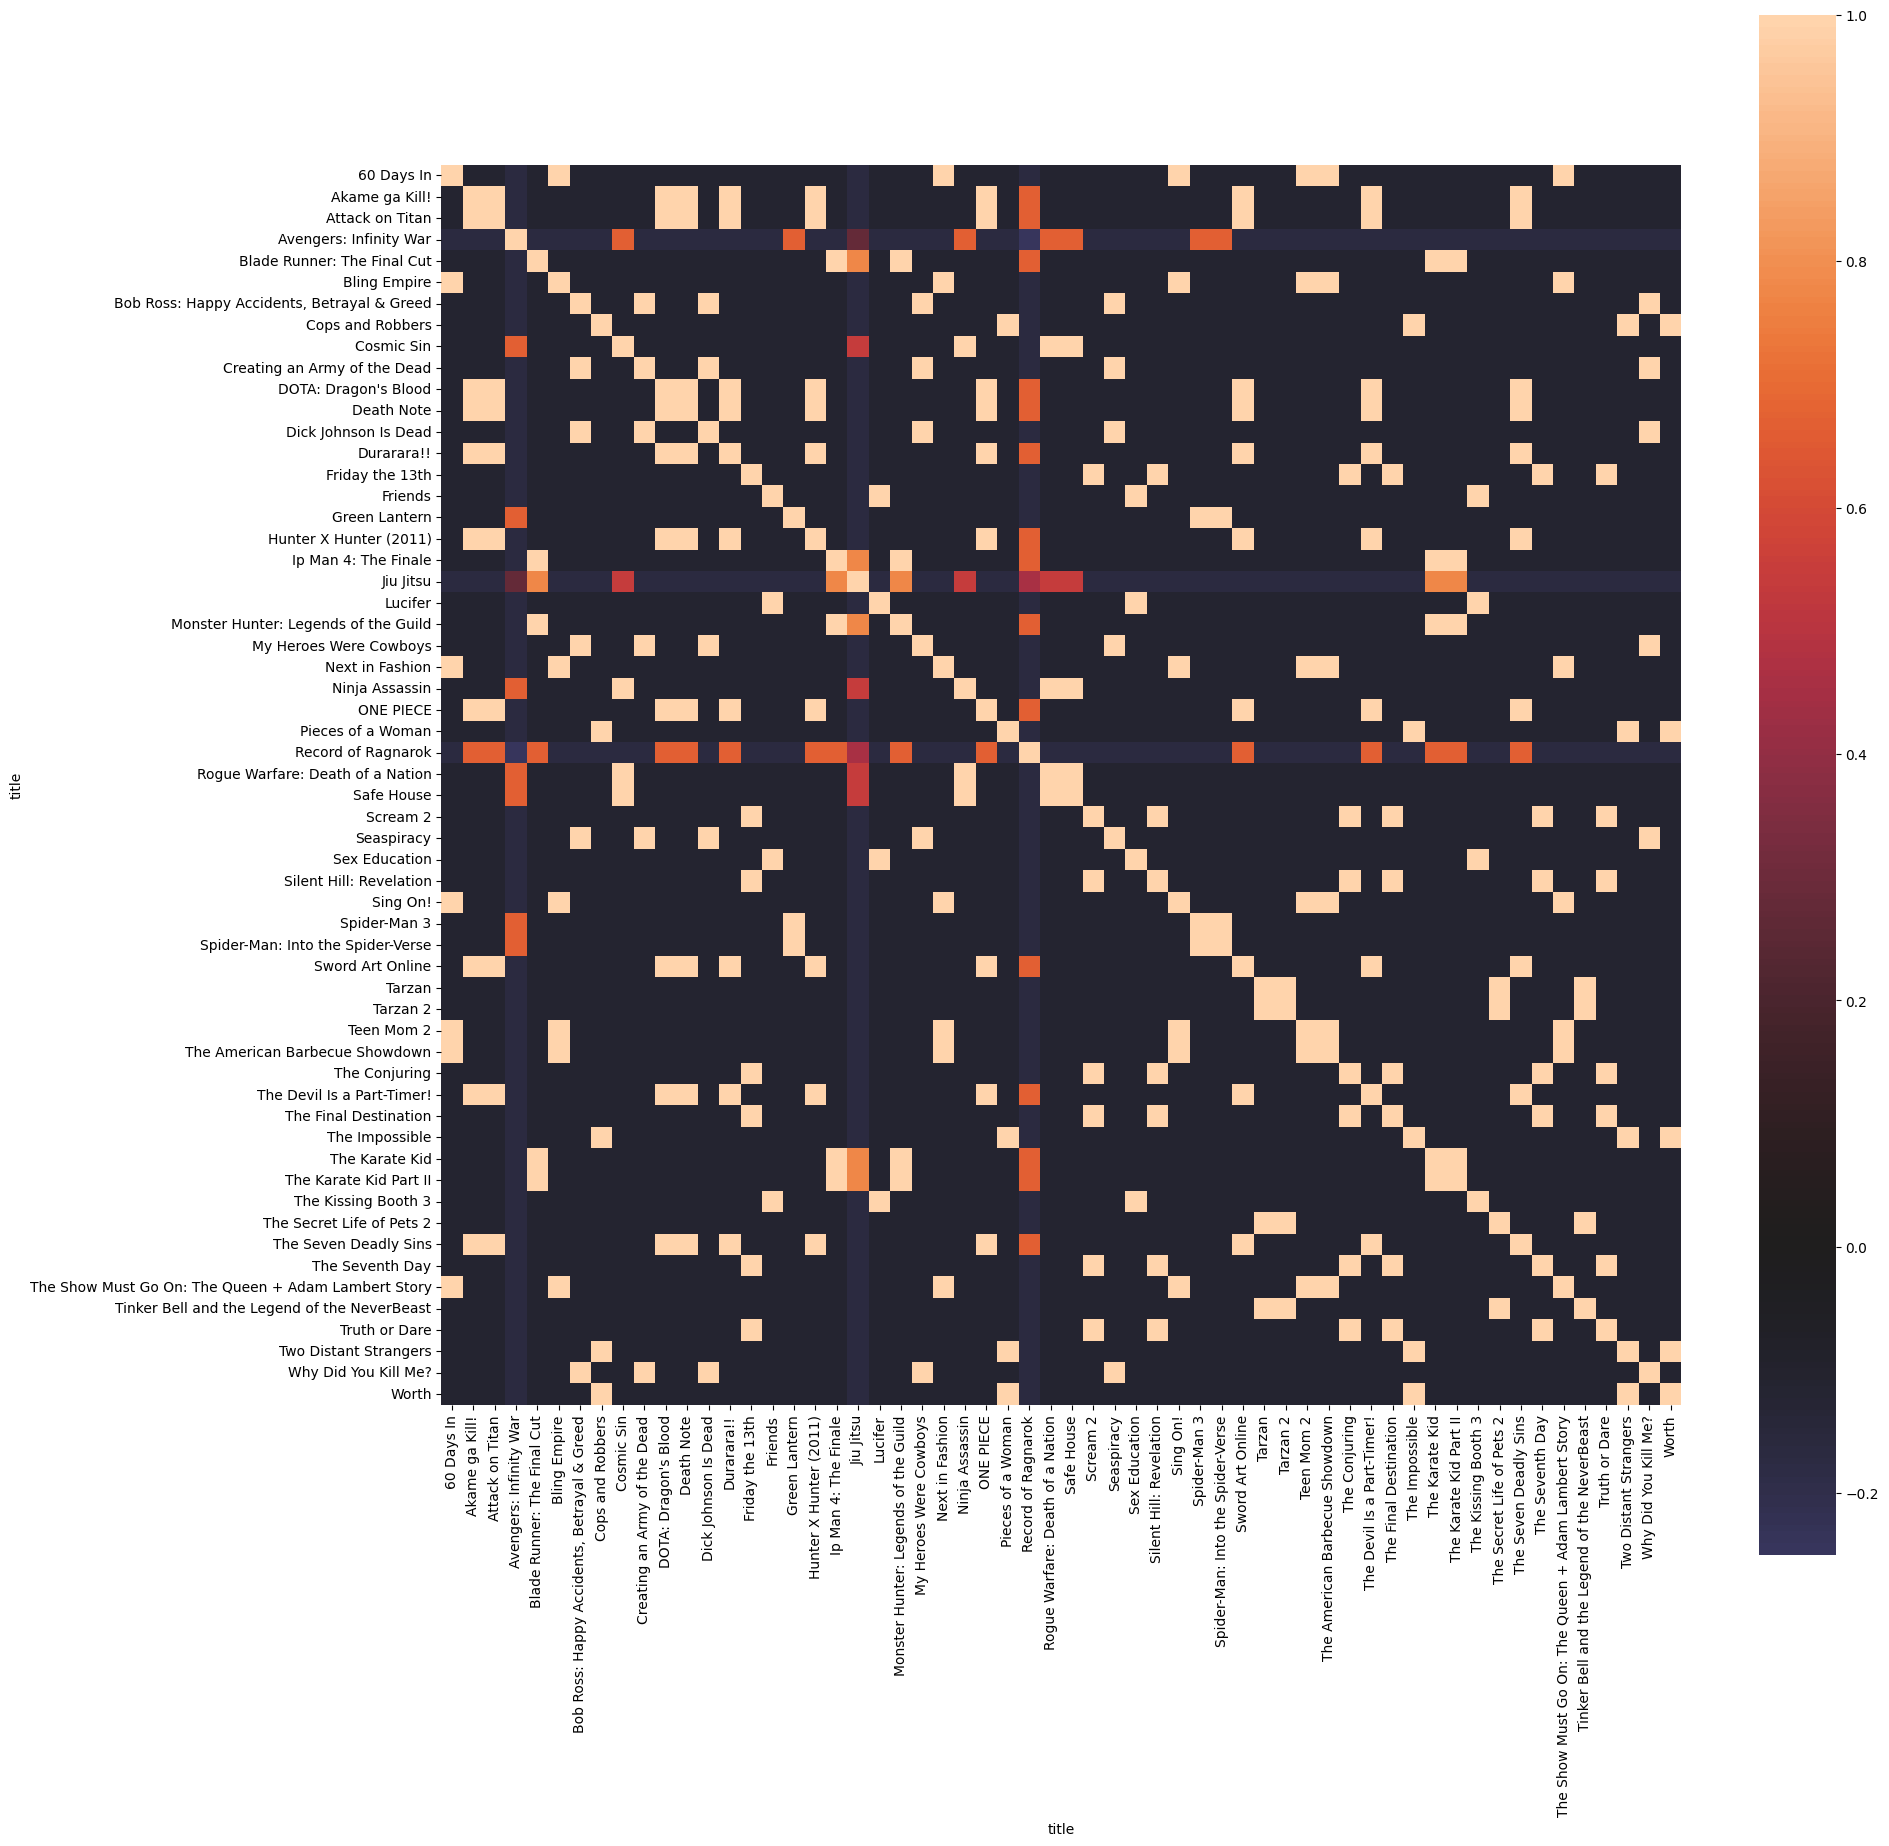

In [27]:
f, ax  =plt.subplots(figsize = (20,20))
sns.heatmap(user_similarity_df, square = True, center = 0, annot = False)

MovieLen Data

In [28]:
user_Msimilarity_df = pd.DataFrame(user_Msimilarity,index=userMRatings.columns,columns=userMRatings.columns)
user_Msimilarity_df

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.000000,-0.001642,-0.002324,-0.001642,-0.002254,-0.001642,-0.006407,-0.001642,0.135943,-0.004325,...,-0.001642,0.339935,0.542247,0.706526,-0.001642,-0.007675,0.134327,0.325287,-0.008185,-0.001642
'Hellboy': The Seeds of Creation (2004),-0.001642,1.000000,0.706526,-0.001642,-0.002254,-0.001642,-0.006407,-0.001642,-0.010568,-0.004325,...,-0.001642,-0.004589,-0.002808,-0.002324,-0.001642,-0.007675,-0.007744,-0.003594,-0.008185,-0.001642
'Round Midnight (1986),-0.002324,0.706526,1.000000,-0.002324,-0.003191,-0.002324,0.170199,-0.002324,-0.014958,-0.006121,...,-0.002324,-0.006495,-0.003975,-0.003289,-0.002324,-0.010863,-0.010961,-0.005087,-0.011585,-0.002324
'Salem's Lot (2004),-0.001642,-0.001642,-0.002324,1.000000,0.857269,-0.001642,-0.006407,-0.001642,-0.010568,-0.004325,...,-0.001642,-0.004589,-0.002808,-0.002324,-0.001642,-0.007675,-0.007744,-0.003594,-0.008185,-0.001642
'Til There Was You (1997),-0.002254,-0.002254,-0.003191,0.857269,1.000000,-0.002254,-0.008797,-0.002254,-0.014510,-0.005938,...,-0.002254,-0.006301,-0.003856,-0.003191,-0.002254,-0.010538,-0.010632,-0.004935,-0.011238,-0.002254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),-0.007675,-0.007675,-0.010863,-0.007675,-0.010538,-0.007675,0.187953,0.212646,0.053614,0.115396,...,-0.007675,-0.021449,-0.013126,-0.010863,-0.007675,1.000000,0.163022,-0.016800,0.138611,-0.007675
xXx (2002),0.134327,-0.007744,-0.010961,-0.007744,-0.010632,-0.007744,0.062174,-0.007744,0.241092,-0.000060,...,0.063291,0.291410,0.163464,0.240394,-0.007744,0.163022,1.000000,0.259049,0.065673,-0.007744
xXx: State of the Union (2005),0.325287,-0.003594,-0.005087,-0.003594,-0.004935,-0.003594,-0.014025,-0.003594,0.139511,-0.009467,...,-0.003594,0.376455,0.172818,0.227658,-0.003594,-0.016800,0.259049,1.000000,-0.017917,-0.003594


In [29]:
newUser_Msimilarity_df = user_Msimilarity_df.iloc[0:75,0:75]


<AxesSubplot: xlabel='title', ylabel='title'>

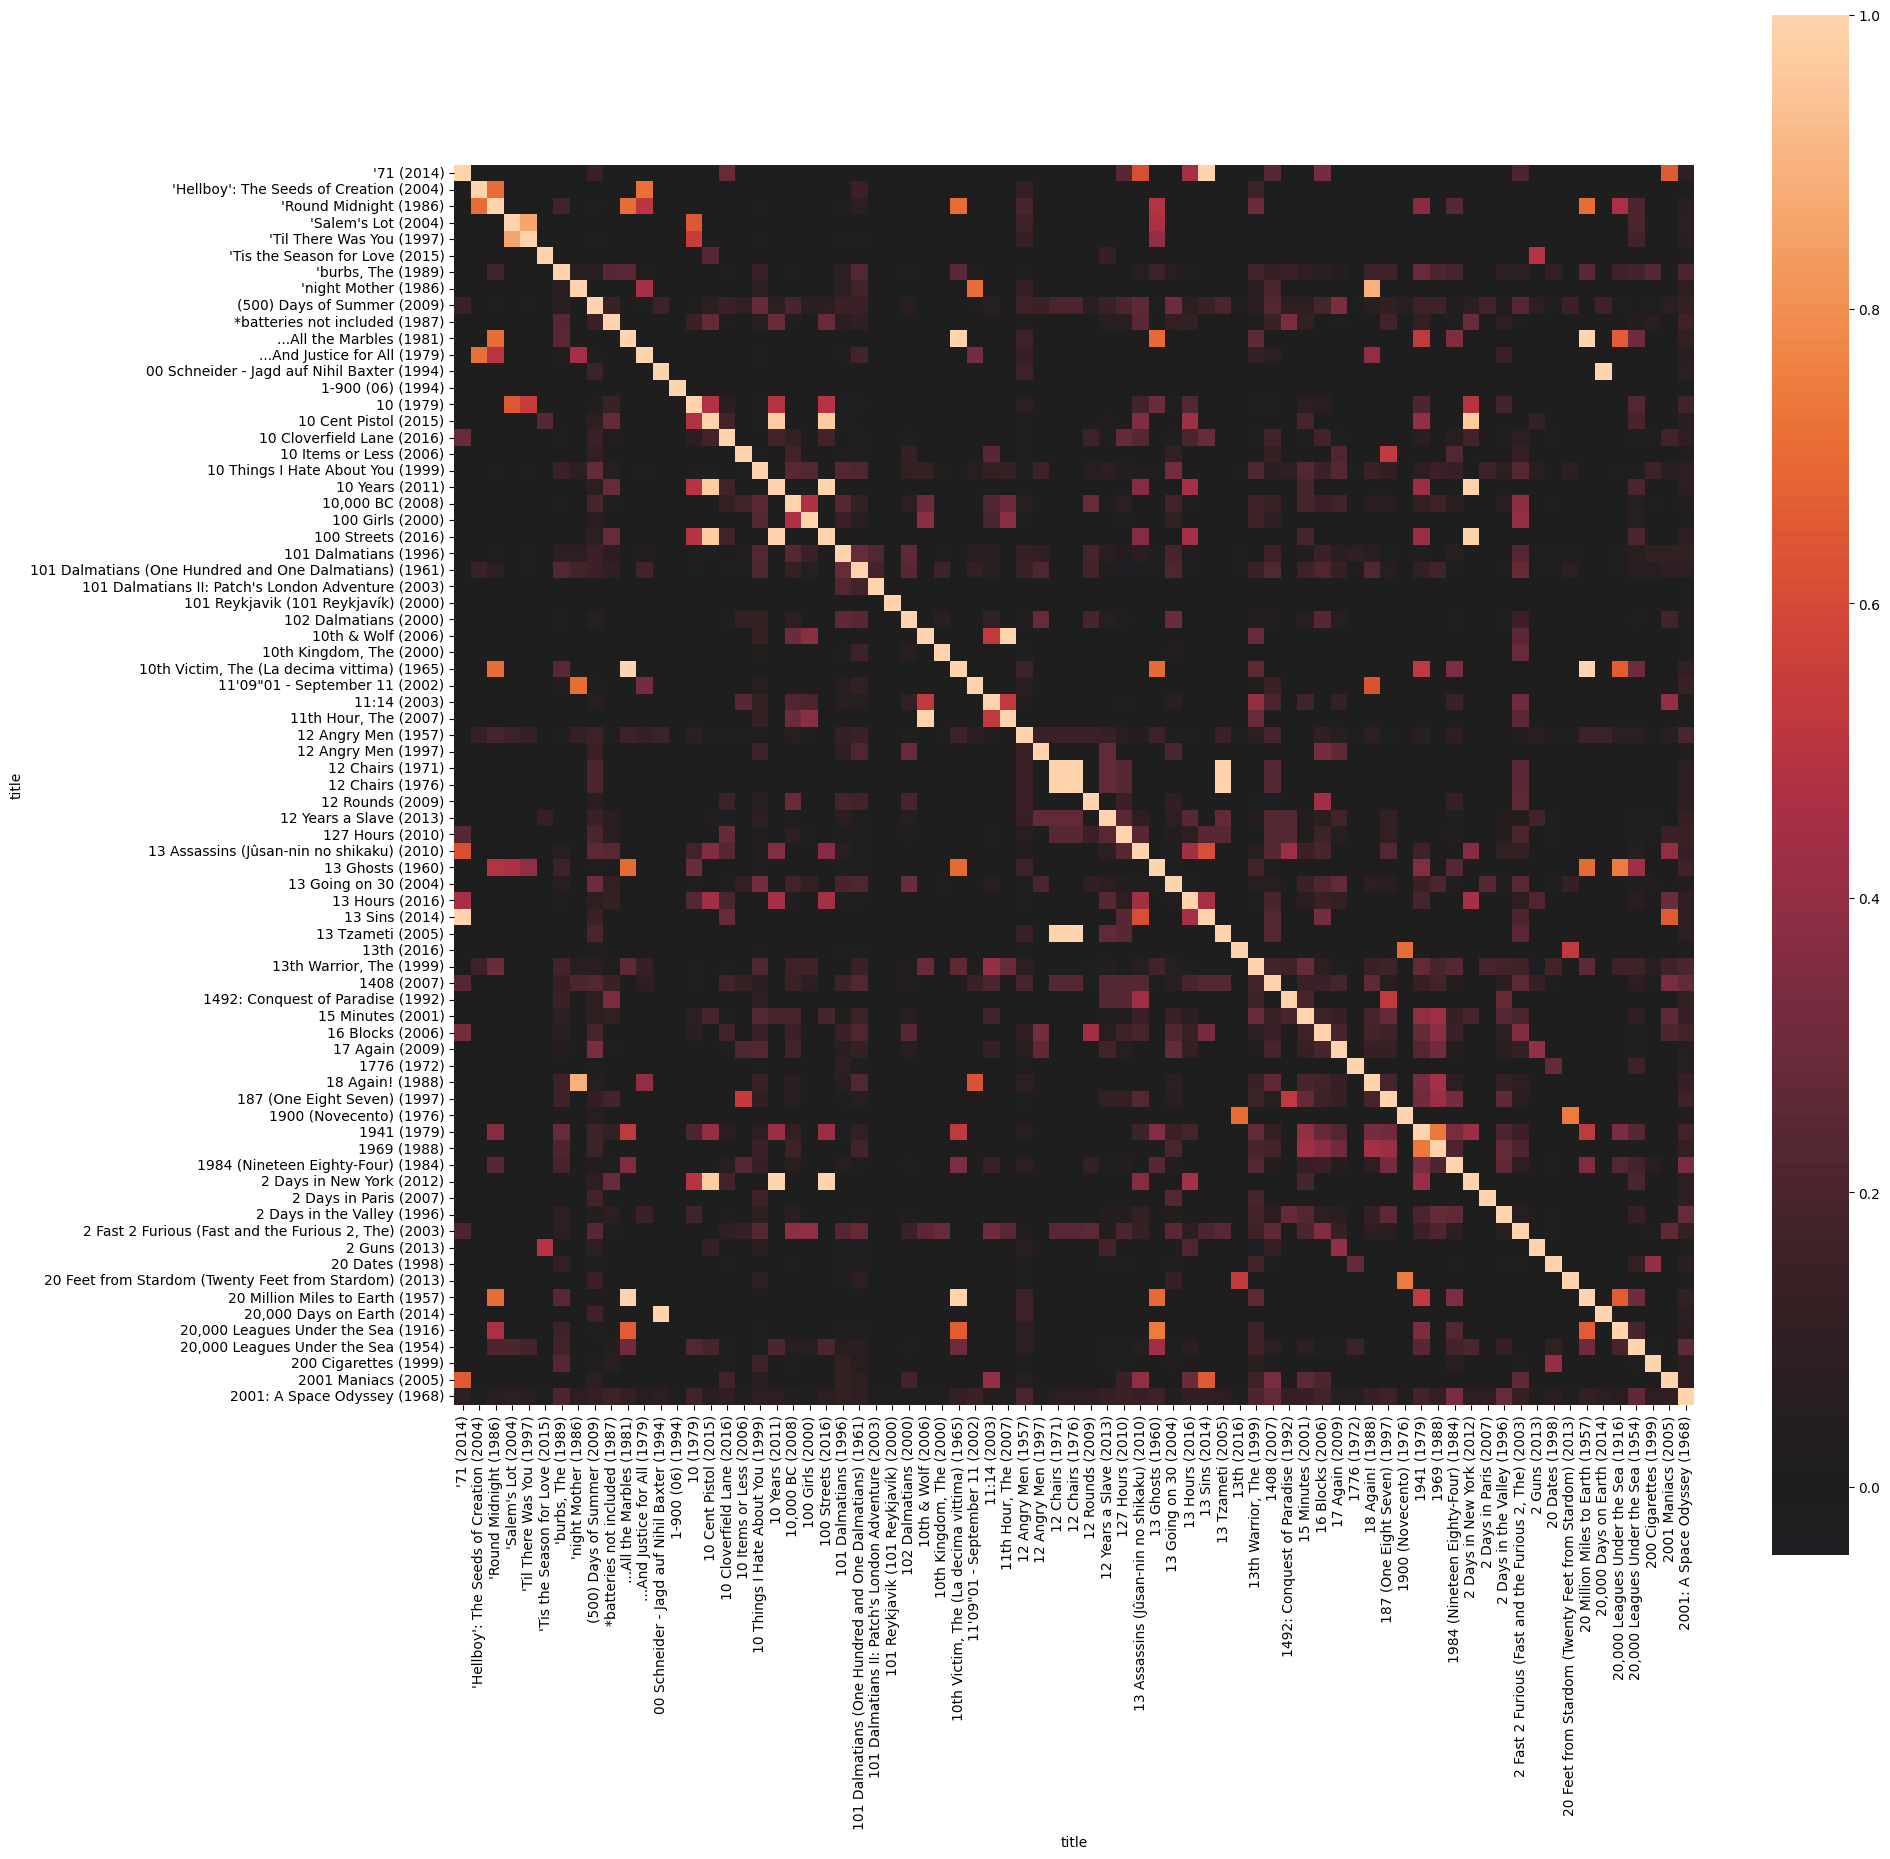

In [30]:
f, ax  =plt.subplots(figsize = (20,20))
sns.heatmap(newUser_Msimilarity_df, square = True, center = 0, annot = False)

In [31]:
def get_similar_cosine(movie_name, user_rating, user_similarity_df):
    similar_score = user_similarity_df[movie_name]
    similar_score = similar_score.sort_values(ascending=False)
    return similar_score

In [32]:
new_user1 = [("ONE PIECE",5),("Sword Art Online",2),("Sex Education",4),("Hunter X Hunter (2011)",5),("Attack on Titan",4)]

similar_movies = pd.DataFrame()
for movie,rating in new_user1:
    similar_movies = similar_movies.append(get_similar_cosine(movie,rating,user_similarity_df),ignore_index = True)

for (x,_) in new_user1:
    del similar_movies[x]
similar_movies.head()

C:\Users\eric2\AppData\Local\Temp\ipykernel_20232\331316919.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_movies = similar_movies.append(get_similar_cosine(movie,rating,user_similarity_df),ignore_index = True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_20232\331316919.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_movies = similar_movies.append(get_similar_cosine(movie,rating,user_similarity_df),ignore_index = True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_20232\331316919.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_movies = similar_movies.append(get_similar_cosine(movie,rating,user_similarity_df),ignore_index = True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_20232\331316919.p

title,The Devil Is a Part-Timer!,DOTA: Dragon's Blood,The Seven Deadly Sins,Akame ga Kill!,Durarara!!,Death Note,Record of Ragnarok,The Karate Kid Part II,The Karate Kid,Blade Runner: The Final Cut,...,Spider-Man 3,Rogue Warfare: Death of a Nation,Pieces of a Woman,Ninja Assassin,Creating an Army of the Dead,Cosmic Sin,Cops and Robbers,Worth,Jiu Jitsu,Avengers: Infinity War
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667,-0.111111,-0.111111,-0.111111,...,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.164581,-0.166667
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667,-0.111111,-0.111111,-0.111111,...,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.164581,-0.166667
2,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.166667,-0.111111,-0.111111,-0.111111,...,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.164581,-0.166667
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667,-0.111111,-0.111111,-0.111111,...,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.164581,-0.166667
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667,-0.111111,-0.111111,-0.111111,...,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.164581,-0.166667


In [33]:
new_user2 = [("Inception (2010)", 5), ("Avengers: Infinity War - Part I (2018)", 4), ("Lion King, The (1994)", 4), ("A Quiet Place (2018)", 4), ("Avatar (2009)", 5)]

similar_Mmovies = pd.DataFrame()
for movie,rating in new_user2:
    similar_Mmovies = similar_Mmovies.append(get_similar_cosine(movie,rating,user_Msimilarity_df),ignore_index = True)

for (x,_) in new_user2:
    del similar_Mmovies[x]
similar_Mmovies.head()

C:\Users\eric2\AppData\Local\Temp\ipykernel_20232\300738570.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_Mmovies = similar_Mmovies.append(get_similar_cosine(movie,rating,user_Msimilarity_df),ignore_index = True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_20232\300738570.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_Mmovies = similar_Mmovies.append(get_similar_cosine(movie,rating,user_Msimilarity_df),ignore_index = True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_20232\300738570.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_Mmovies = similar_Mmovies.append(get_similar_cosine(movie,rating,user_Msimilarity_df),ignore_index = True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_20232\30

title,"Dark Knight, The (2008)",Inglourious Basterds (2009),Shutter Island (2010),"Dark Knight Rises, The (2012)",Interstellar (2014),"Avengers, The (2012)",Up (2009),Django Unchained (2012),"Social Network, The (2010)",Iron Man (2008),...,Cliffhanger (1993),"Madness of King George, The (1994)","Piano, The (1993)",Star Trek: Generations (1994),"Firm, The (1993)",Crimson Tide (1995),True Lies (1994),Disclosure (1994),Get Shorty (1995),Clear and Present Danger (1994)
0,0.646113,0.574834,0.557746,0.549934,0.541386,0.519195,0.514463,0.510479,0.491725,0.480998,...,-0.117963,-0.118423,-0.120663,-0.121680,-0.123244,-0.127539,-0.130696,-0.149917,-0.162090,-0.193168
1,0.225907,0.196712,0.241099,0.283297,0.229449,0.274330,0.208002,0.138302,0.157210,0.301064,...,0.010654,-0.031490,-0.045435,-0.008654,-0.061340,-0.022647,0.038892,-0.042274,-0.035336,-0.064829
2,0.161202,0.075084,0.116458,0.103551,0.087591,0.114559,0.176499,0.085448,0.118530,0.152235,...,0.349516,0.046577,0.140426,0.282748,0.321094,0.282162,0.353558,0.207169,0.233214,0.269892
3,0.080441,0.171411,0.201416,0.116580,0.160398,0.089948,0.059075,0.075424,0.189678,0.062658,...,0.055695,-0.015745,-0.022717,-0.031865,-0.030670,0.042397,0.026294,-0.021137,-0.028368,-0.032414
4,0.447723,0.431010,0.384880,0.371441,0.358363,0.497880,0.567484,0.448918,0.403393,0.559671,...,-0.049817,-0.067004,-0.098948,-0.016125,-0.095928,-0.057028,0.003800,-0.103304,-0.086680,-0.094719


Top 10 netflix recommendations

In [34]:
similar_movies.sum().sort_values(ascending=False).head(10)

title
The Devil Is a Part-Timer!    3.888889
Durarara!!                    3.888889
Death Note                    3.888889
DOTA: Dragon's Blood          3.888889
Akame ga Kill!                3.888889
The Seven Deadly Sins         3.888889
Record of Ragnarok            2.500000
The Kissing Booth 3           0.555556
Lucifer                       0.555556
Friends                       0.555556
dtype: float64

In [35]:
similar_Mmovies.sum().sort_values(ascending=False).head(10)

title
Untitled Spider-Man Reboot (2017)    1.619482
Deadpool 2 (2018)                    1.597082
Dark Knight, The (2008)              1.561386
Iron Man (2008)                      1.556626
Guardians of the Galaxy (2014)       1.531743
Up (2009)                            1.525522
Alien: Covenant (2017)               1.505958
Ant-Man (2015)                       1.505680
Sherlock Holmes (2009)               1.504437
Shutter Island (2010)                1.501598
dtype: float64

## Pearson Similarity Recommendation System

In [36]:
corrMatrix = userRatings.corr(method='pearson')
corrMatrix.head(10)

title,60 Days In,Akame ga Kill!,Attack on Titan,Avengers: Infinity War,Blade Runner: The Final Cut,Bling Empire,"Bob Ross: Happy Accidents, Betrayal & Greed",Cops and Robbers,Cosmic Sin,Creating an Army of the Dead,...,The Kissing Booth 3,The Secret Life of Pets 2,The Seven Deadly Sins,The Seventh Day,The Show Must Go On: The Queen + Adam Lambert Story,Tinker Bell and the Legend of the NeverBeast,Truth or Dare,Two Distant Strangers,Why Did You Kill Me?,Worth
title,,,,,,,,,,,,,,,,,,,,,
60 Days In,1.000000,-0.111111,-0.111111,-0.166667,-0.111111,1.000000,-0.111111,-0.111111,-0.111111,-0.111111,...,-0.111111,-0.111111,-0.111111,-0.111111,1.000000,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111
Akame ga Kill!,-0.111111,1.000000,1.000000,-0.166667,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,...,-0.111111,-0.111111,1.000000,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111
Attack on Titan,-0.111111,1.000000,1.000000,-0.166667,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,...,-0.111111,-0.111111,1.000000,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111
Avengers: Infinity War,-0.166667,-0.166667,-0.166667,1.000000,-0.166667,-0.166667,-0.166667,-0.166667,0.666667,-0.166667,...,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667
Blade Runner: The Final Cut,-0.111111,-0.111111,-0.111111,-0.166667,1.000000,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,...,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111
Bling Empire,1.000000,-0.111111,-0.111111,-0.166667,-0.111111,1.000000,-0.111111,-0.111111,-0.111111,-0.111111,...,-0.111111,-0.111111,-0.111111,-0.111111,1.000000,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111
"Bob Ross: Happy Accidents, Betrayal & Greed",-0.111111,-0.111111,-0.111111,-0.166667,-0.111111,-0.111111,1.000000,-0.111111,-0.111111,1.000000,...,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,1.000000,-0.111111
Cops and Robbers,-0.111111,-0.111111,-0.111111,-0.166667,-0.111111,-0.111111,-0.111111,1.000000,-0.111111,-0.111111,...,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,1.000000,-0.111111,1.000000
Cosmic Sin,-0.111111,-0.111111,-0.111111,0.666667,-0.111111,-0.111111,-0.111111,-0.111111,1.000000,-0.111111,...,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111


In [37]:
corrMMatrix = userMRatings.corr(method='pearson')
corrMMatrix.head(10)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.000000,-0.001642,-0.002324,-0.001642,-0.002254,-0.001642,-0.006407,-0.001642,0.135943,-0.004325,...,-0.001642,0.339935,0.542247,0.706526,-0.001642,-0.007675,0.134327,0.325287,-0.008185,-0.001642
'Hellboy': The Seeds of Creation (2004),-0.001642,1.000000,0.706526,-0.001642,-0.002254,-0.001642,-0.006407,-0.001642,-0.010568,-0.004325,...,-0.001642,-0.004589,-0.002808,-0.002324,-0.001642,-0.007675,-0.007744,-0.003594,-0.008185,-0.001642
'Round Midnight (1986),-0.002324,0.706526,1.000000,-0.002324,-0.003191,-0.002324,0.170199,-0.002324,-0.014958,-0.006121,...,-0.002324,-0.006495,-0.003975,-0.003289,-0.002324,-0.010863,-0.010961,-0.005087,-0.011585,-0.002324
'Salem's Lot (2004),-0.001642,-0.001642,-0.002324,1.000000,0.857269,-0.001642,-0.006407,-0.001642,-0.010568,-0.004325,...,-0.001642,-0.004589,-0.002808,-0.002324,-0.001642,-0.007675,-0.007744,-0.003594,-0.008185,-0.001642
'Til There Was You (1997),-0.002254,-0.002254,-0.003191,0.857269,1.000000,-0.002254,-0.008797,-0.002254,-0.014510,-0.005938,...,-0.002254,-0.006301,-0.003856,-0.003191,-0.002254,-0.010538,-0.010632,-0.004935,-0.011238,-0.002254
'Tis the Season for Love (2015),-0.001642,-0.001642,-0.002324,-0.001642,-0.002254,1.000000,-0.006407,-0.001642,-0.010568,-0.004325,...,-0.001642,-0.004589,-0.002808,-0.002324,-0.001642,-0.007675,-0.007744,-0.003594,-0.008185,-0.001642
"'burbs, The (1989)",-0.006407,-0.006407,0.170199,-0.006407,-0.008797,-0.006407,1.000000,0.065968,0.063117,0.235908,...,-0.006407,-0.017905,-0.010957,-0.009068,-0.006407,0.187953,0.062174,-0.014025,0.353194,-0.006407
'night Mother (1986),-0.001642,-0.001642,-0.002324,-0.001642,-0.002254,-0.001642,0.065968,1.000000,-0.010568,-0.004325,...,-0.001642,-0.004589,-0.002808,-0.002324,-0.001642,0.212646,-0.007744,-0.003594,0.175610,-0.001642
(500) Days of Summer (2009),0.135943,-0.010568,-0.014958,-0.010568,-0.014510,-0.010568,0.063117,-0.010568,1.000000,0.133949,...,0.094083,0.126147,0.061652,0.088726,-0.010568,0.053614,0.241092,0.139511,0.125905,-0.010568


In [38]:
def get_similar_pearson(movie_name, user_rating, corrMatrix):
    similar_score = corrMatrix[movie_name]*(user_rating-2.5)
    similar_score = similar_score.sort_values(ascending=False)
    return similar_score

To run the search similarity - Adjust the parameters of the new_user1 = [("Movie", ratings) , ("Movie", ratings)]

In [39]:
new_user1 = [("ONE PIECE",5),("Sword Art Online",2),("Sex Education",4),("Hunter X Hunter (2011)",5),("Attack on Titan",4)]
similar_movies = pd.DataFrame()
for movie,rating in new_user1:
    similar_movies = similar_movies.append(get_similar_pearson(movie,rating, corrMatrix),ignore_index = True)

for (x,_) in new_user1:
    del similar_movies[x]
similar_movies.head()

C:\Users\eric2\AppData\Local\Temp\ipykernel_20232\2451973499.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_movies = similar_movies.append(get_similar_pearson(movie,rating, corrMatrix),ignore_index = True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_20232\2451973499.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_movies = similar_movies.append(get_similar_pearson(movie,rating, corrMatrix),ignore_index = True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_20232\2451973499.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_movies = similar_movies.append(get_similar_pearson(movie,rating, corrMatrix),ignore_index = True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_20232\2451973499.py:4: FutureWar

title,Akame ga Kill!,Durarara!!,Death Note,The Devil Is a Part-Timer!,The Seven Deadly Sins,DOTA: Dragon's Blood,Record of Ragnarok,The Impossible,Tarzan,Friends,...,Creating an Army of the Dead,The Seventh Day,Truth or Dare,Silent Hill: Revelation,The Final Destination,The Conjuring,Scream 2,Seaspiracy,Jiu Jitsu,Avengers: Infinity War
0,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,1.666667,-0.277778,-0.277778,-0.277778,...,-0.277778,-0.277778,-0.277778,-0.277778,-0.277778,-0.277778,-0.277778,-0.277778,-0.411452,-0.416667
1,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.333333,0.055556,0.055556,0.055556,...,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.082290,0.083333
2,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.250000,-0.166667,-0.166667,1.500000,...,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.246871,-0.250000
3,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,1.666667,-0.277778,-0.277778,-0.277778,...,-0.277778,-0.277778,-0.277778,-0.277778,-0.277778,-0.277778,-0.277778,-0.277778,-0.411452,-0.416667
4,1.500000,1.500000,1.500000,1.500000,1.500000,1.500000,1.000000,-0.166667,-0.166667,-0.166667,...,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.246871,-0.250000


In [40]:
similar_movies.sum().sort_values(ascending=False).head(10)

title
Akame ga Kill!                5.833333
The Devil Is a Part-Timer!    5.833333
Durarara!!                    5.833333
Death Note                    5.833333
DOTA: Dragon's Blood          5.833333
The Seven Deadly Sins         5.833333
Record of Ragnarok            3.750000
The Kissing Booth 3           0.833333
Friends                       0.833333
Lucifer                       0.833333
dtype: float64

To run the search similarity - Adjust the parameters of the new_user2 = [("Movie", ratings) , ("Movie", ratings)]

In [41]:
new_user2 = [("Inception (2010)", 5), ("Avengers: Infinity War - Part I (2018)", 4), ("Lion King, The (1994)", 4), ("A Quiet Place (2018)", 4), ("Avatar (2009)", 5)]
similar_Mmovies = pd.DataFrame()
for movie,rating in new_user2:
    similar_Mmovies = similar_Mmovies.append(get_similar_pearson(movie,rating, corrMMatrix),ignore_index = True)

for (x,_) in new_user2:
    del similar_Mmovies[x]
similar_Mmovies.head()

C:\Users\eric2\AppData\Local\Temp\ipykernel_20232\1268381869.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_Mmovies = similar_Mmovies.append(get_similar_pearson(movie,rating, corrMMatrix),ignore_index = True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_20232\1268381869.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_Mmovies = similar_Mmovies.append(get_similar_pearson(movie,rating, corrMMatrix),ignore_index = True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_20232\1268381869.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_Mmovies = similar_Mmovies.append(get_similar_pearson(movie,rating, corrMMatrix),ignore_index = True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_20232\1268381869.py:4: 

title,"Dark Knight, The (2008)",Inglourious Basterds (2009),Shutter Island (2010),"Dark Knight Rises, The (2012)",Interstellar (2014),"Avengers, The (2012)",Up (2009),Django Unchained (2012),"Social Network, The (2010)",Iron Man (2008),...,Cliffhanger (1993),"Madness of King George, The (1994)","Piano, The (1993)",Star Trek: Generations (1994),"Firm, The (1993)",Crimson Tide (1995),True Lies (1994),Disclosure (1994),Get Shorty (1995),Clear and Present Danger (1994)
0,1.615283,1.437085,1.394365,1.374834,1.353466,1.297987,1.286157,1.276198,1.229312,1.202496,...,-0.294907,-0.296058,-0.301658,-0.304200,-0.308111,-0.318846,-0.326740,-0.374793,-0.405226,-0.482921
1,0.338861,0.295067,0.361648,0.424946,0.344173,0.411495,0.312002,0.207452,0.235814,0.451596,...,0.015981,-0.047234,-0.068152,-0.012981,-0.092010,-0.033970,0.058339,-0.063411,-0.053003,-0.097243
2,0.241803,0.112627,0.174687,0.155326,0.131386,0.171839,0.264749,0.128172,0.177795,0.228353,...,0.524274,0.069865,0.210639,0.424123,0.481640,0.423243,0.530337,0.310754,0.349821,0.404838
3,0.120661,0.257116,0.302124,0.174870,0.240598,0.134921,0.088612,0.113137,0.284518,0.093986,...,0.083543,-0.023617,-0.034076,-0.047797,-0.046005,0.063595,0.039442,-0.031705,-0.042552,-0.048621
4,1.119308,1.077525,0.962199,0.928602,0.895908,1.244699,1.418710,1.122295,1.008483,1.399178,...,-0.124543,-0.167509,-0.247370,-0.040313,-0.239820,-0.142571,0.009499,-0.258260,-0.216699,-0.236799


In [42]:
similar_Mmovies.sum().sort_values(ascending=False).head(10)

title
Dark Knight, The (2008)           3.435916
Iron Man (2008)                   3.375609
Up (2009)                         3.370230
Avengers, The (2012)              3.260942
Hangover, The (2009)              3.249295
Sherlock Holmes (2009)            3.223721
Guardians of the Galaxy (2014)    3.217329
WALL·E (2008)                     3.201764
Shutter Island (2010)             3.195023
Inglourious Basterds (2009)       3.179420
dtype: float64

#### Evaluation Metric : RMSE ( Root Mean Squared Error )

In [43]:
# Function to predict ratings
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [44]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to calculate RMSE
def rmse(pred, actual):
    return sqrt(mean_squared_error(pred, actual))

# Predict ratings on the training data with both similarity score
user_prediction = predict(euclidean_dist, corrMatrix, type='user')
item_prediction = predict(euclidean_dist, corrMatrix, type='item')
# RMSE on the train data
print('User-based CF RMSE: ' + str(rmse(user_prediction, corrMatrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, corrMatrix)))

User-based CF RMSE: 1.4075937705492223
Item-based CF RMSE: 0.623415600864975


# USER-USER COLLABORATIVE FILTERING USING SIMILAR GENRE AVERAGE RATING

## MOVIE LENS

 Retrieving Data from CSV

In [45]:
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.merge(movies, ratings)

ratings.drop('timestamp', axis = 1, inplace=True)
ratings.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5


## Pre-processing of data

Filling non value data as 0

In [46]:
ratings['rating'] = ratings['rating'].fillna('0')
ratings.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5


#### Converting strings into lower case, removing of stop words and splitting of words

In [47]:
ratings['clean_genre'] = ratings['genres'].str.lower()
ratings['clean_genre'] = ratings['clean_genre'].apply(lambda x: re.sub(' ', '', x))
ratings['clean_genre'] = ratings['clean_genre'].apply(lambda x: re.sub('\s+', ' ', x))
ratings['clean_genre'] = ratings['clean_genre'].apply(lambda x: x.split('|'))
ratings

,movieId,title,genres,userId,rating,clean_genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,"[adventure, animation, children, comedy, fantasy]"
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,"[adventure, animation, children, comedy, fantasy]"
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,"[adventure, animation, children, comedy, fantasy]"
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,"[adventure, animation, children, comedy, fantasy]"
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,"[adventure, animation, children, comedy, fantasy]"
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,"[action, animation, comedy, fantasy]"
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,"[animation, comedy, fantasy]"
100833,193585,Flint (2017),Drama,184,3.5,[drama]
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,"[action, animation]"


In [48]:
genre_ratings = ratings[['title', 'userId', 'rating', 'clean_genre']].copy()
genre_ratings.head()

,title,userId,rating,clean_genre
0,Toy Story (1995),1,4.0,"[adventure, animation, children, comedy, fantasy]"
1,Toy Story (1995),5,4.0,"[adventure, animation, children, comedy, fantasy]"
2,Toy Story (1995),7,4.5,"[adventure, animation, children, comedy, fantasy]"
3,Toy Story (1995),15,2.5,"[adventure, animation, children, comedy, fantasy]"
4,Toy Story (1995),17,4.5,"[adventure, animation, children, comedy, fantasy]"


## Creating functions for recommending movies of similar genres

### Similar Genre Average Rating Function that searches for genre type movies and returns the dataframe of movies

##### Get the similar genre out of the user input and the database

In [49]:
def get_similar_genre(genre):
    temp = []
    df = pd.DataFrame()
    for i, x in enumerate(genre_ratings['clean_genre']):
        if (all(elem in x for elem in genre)):
            temp.append(i)
                    
    temp = set(temp)
    temp = list(temp)
    df = genre_ratings.iloc[temp]
    return df

##### Print function for list

In [50]:
def printList(list):
    for x in list:
        print(x)

##### Similar Genre Average Rating Function to get the recommendation for the user based on genre
##### The genre should be inserted in accordance to ranking, meaning index 0 should be the most favourite genre

["Comedy" , "Action", "Horror"] -> Rank 1: Comedy, Rank 2: Action, Rank 3: Horror

In [51]:
def get_recommendation(genre, xList):
    df_genre = pd.DataFrame()
    df_genre = get_similar_genre(genre)
    index_list = xList
    
    #Creates a table that shows different user and their ratings to different movie titles
    recc_ratings = df_genre.pivot_table(index=['userId'],columns=['title'],values='rating')
    recc_ratings.fillna(0, inplace=True)
    
    #Sum the total ratings from all users for each movie title
    recc_columns = recc_ratings.sum(axis=0).sort_values(ascending=False)
    recc_columns = pd.DataFrame(recc_columns)
    recc_columns['sum'] = recc_ratings.sum(axis=0).sort_values(ascending=False)
    del recc_columns[recc_columns.columns[0]]
    
    #Count the number of users that have rated the movie
    recc_normalization = df_genre['title'].value_counts()
    recc_normalization = pd.DataFrame(recc_normalization)
    recc_normalization.rename(columns={'title':'count'}, inplace=True)
    
    recc_merge = recc_columns.join(recc_normalization)
    
    #Normalizing + removing count values <= 20
    recc_merge['normalize'] = (recc_merge['sum']/recc_merge['count'])
    print(recc_merge)
    recc_merge['count'].dtypes
    recc_merge = recc_merge[(recc_merge['count'] > 20)]
    #If the reccommendation list is less than 5, recursively call the function
    if (len(recc_merge) < 5):
        if (len(genre) != 0):
            get_recommendation(genre[:(len(genre)-1)], index_list)
    else :
        recc_merge.sort_values(by='count', ascending=False).head(10)
        for i in recc_merge.index.values.tolist():
            index_list.append(i)
        #index_list = (recc_merge.index.values.tolist())
        print("Top Recommendations: ")
        
    
    return index_list[:5]

Calling the recommendation system function for favourite genre crime & drama

In [52]:
get_recommendation(["crime", "drama"], [])

                                     sum  count  normalize
title                                                     
Shawshank Redemption, The (1994)  1404.0    317   4.429022
Pulp Fiction (1994)               1288.5    307   4.197068
Fight Club (1999)                  931.5    218   4.272936
Godfather, The (1972)              823.5    192   4.289062
Fargo (1996)                       745.0    181   4.116022
...                                  ...    ...        ...
Circus (2000)                        1.0      1   1.000000
Unforgiven (2013)                    0.5      1   0.500000
I Know Who Killed Me (2007)          0.5      1   0.500000
Baby Boy (2001)                      0.5      1   0.500000
Sorrow (2015)                        0.5      1   0.500000

[634 rows x 3 columns]
Top Recommendations: 


['Shawshank Redemption, The (1994)',
 'Pulp Fiction (1994)',
 'Fight Club (1999)',
 'Godfather, The (1972)',
 'Fargo (1996)']

In [53]:
get_recommendation(["children", "action", "adventure", "drama", "horror"], [])

Empty DataFrame
Columns: [sum, count, normalize]
Index: []
                                   sum  count  normalize
title                                                   
Karate Kid, Part III, The (1989)  24.5     14       1.75
                                                      sum  count  normalize
title                                                                      
Incredibles, The (2004)                             479.5    125   3.836000
Goonies, The (1985)                                 203.5     57   3.570175
Zootopia (2016)                                     124.5     32   3.890625
The Lego Movie (2014)                               120.0     31   3.870968
Brave (2012)                                        104.0     30   3.466667
Titan A.E. (2000)                                    99.0     29   3.413793
Laputa: Castle in the Sky (Tenkû no shiro Rapyu...   97.5     24   4.062500
Spy Kids (2001)                                      82.5     28   2.946429
Rango (201

['Incredibles, The (2004)',
 'Goonies, The (1985)',
 'Zootopia (2016)',
 'The Lego Movie (2014)',
 'Brave (2012)']

In [54]:
get_recommendation(["children"], [])

                                        sum  count  normalize
title                                                        
Toy Story (1995)                      843.0    215   3.920930
Aladdin (1992)                        694.0    183   3.792350
Lion King, The (1994)                 678.0    172   3.941860
Shrek (2001)                          657.5    170   3.867647
Finding Nemo (2003)                   558.5    141   3.960993
...                                     ...    ...        ...
The Star Wars Holiday Special (1978)    0.5      1   0.500000
Born to Be Wild (1995)                  0.5      1   0.500000
Tooth Fairy 2 (2012)                    0.5      1   0.500000
Arthur Christmas (2011)                 0.5      1   0.500000
Are We There Yet? (2005)                0.5      1   0.500000

[664 rows x 3 columns]
Top Recommendations: 


['Toy Story (1995)',
 'Aladdin (1992)',
 'Lion King, The (1994)',
 'Shrek (2001)',
 'Finding Nemo (2003)']

#### Checking if the user is satisfied with the recommendation or not

In [55]:
def get_sat(list):
    tempdict = {}
    for i in list:
        selection = input("Are you satisfied with " + i + " recommendation? [Y/N]").lower()
        tempdict[i] = selection
        
    return tempdict

In [56]:
get_sat(get_recommendation(["children", "action"], []))

                                     sum  count  normalize
title                                                     
Incredibles, The (2004)            479.5    125   3.836000
Goonies, The (1985)                203.5     57   3.570175
Kung Fu Panda (2008)               186.0     54   3.444444
Zootopia (2016)                    124.5     32   3.890625
The Lego Movie (2014)              120.0     31   3.870968
...                                  ...    ...        ...
Catch That Kid (2004)                2.0      1   2.000000
Batman/Superman Movie, The (1998)    2.0      1   2.000000
Mr. Nanny (1993)                     1.5      1   1.500000
Ratchet & Clank (2016)               1.5      1   1.500000
3 Ninjas Knuckle Up (1995)           0.5      1   0.500000

[77 rows x 3 columns]
Top Recommendations: 


{'Incredibles, The (2004)': 'y',
 'Goonies, The (1985)': 'y',
 'Kung Fu Panda (2008)': 'y',
 'Zootopia (2016)': 'y',
 'The Lego Movie (2014)': 'y'}

## Netflix Data Similar Genre Average Ratings Recommendation Function

In [57]:
netflix_ratings = pd.read_csv('userDatas.csv')
netflix_movies = pd.read_csv('netflix_titles.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

#movies

### Pre-processing of IMDB movie data and netflix data

In [58]:
movies.title = movies.title.str.replace('\d+', '')
movies.title = movies.title.str.replace('(', '')
movies.title = movies.title.str.replace(')', '')
movies['title'] = movies['title'].str.strip()
movies

C:\Users\eric2\AppData\Local\Temp\ipykernel_20232\1278381041.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  movies.title = movies.title.str.replace('\d+', '')
C:\Users\eric2\AppData\Local\Temp\ipykernel_20232\1278381041.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movies.title = movies.title.str.replace('(', '')
C:\Users\eric2\AppData\Local\Temp\ipykernel_20232\1278381041.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movies.title = movies.title.str.replace(')', '')


,movieId,title,genres
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji,Adventure|Children|Fantasy
2,3,Grumpier Old Men,Comedy|Romance
3,4,Waiting to Exhale,Comedy|Drama|Romance
4,5,Father of the Bride Part II,Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero,Animation|Comedy|Fantasy
9739,193585,Flint,Drama
9740,193587,Bungo Stray Dogs: Dead Apple,Action|Animation


In [59]:
netflix_movies

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."


Merge Movie Lens data and Netflix data to retrieve ratings for netflix shows for ratings

In [60]:
overall_movies = movies.merge(netflix_movies, on='title', how='left')
overall_movies

,movieId,title,genres,show_id,type,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Jumanji,Adventure|Children|Fantasy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Grumpier Old Men,Comedy|Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Waiting to Exhale,Comedy|Drama|Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Father of the Bride Part II,Comedy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9738,193583,No Game No Life: Zero,Animation|Comedy|Fantasy,s3171,Movie,Atsuko Ishizuka,"Yoshitsugu Matsuoka, Ai Kayano, Yoko Hikasa, Y...",Japan,"December 6, 2019",2017.0,TV-MA,106 min,"Action & Adventure, Anime Features, Internatio...","In ancient Disboard, a young warrior befriends..."
9739,193585,Flint,Drama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9740,193587,Bungo Stray Dogs: Dead Apple,Action|Animation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
overall_movies = overall_movies.dropna()

In [62]:
overall_movies = overall_movies[['movieId', 'title', 'genres']]
overall_movies = overall_movies.merge(ratings)
overall_movies = overall_movies.drop('timestamp', axis='columns')
overall_movies

,movieId,title,genres,userId,rating
0,7,Sabrina,Comedy|Romance,6,4.0
1,7,Sabrina,Comedy|Romance,14,3.0
2,7,Sabrina,Comedy|Romance,19,2.0
3,7,Sabrina,Comedy|Romance,31,4.0
4,7,Sabrina,Comedy|Romance,32,4.0
...,...,...,...,...,...
12650,187595,Solo: A Star Wars Story,Action|Adventure|Children|Sci-Fi,586,5.0
12651,188301,Ant-Man and the Wasp,Action|Adventure|Comedy|Fantasy|Sci-Fi,50,3.0
12652,188301,Ant-Man and the Wasp,Action|Adventure|Comedy|Fantasy|Sci-Fi,380,4.0
12653,188301,Ant-Man and the Wasp,Action|Adventure|Comedy|Fantasy|Sci-Fi,596,4.0


Clean and split the genre in the merged dataframe

In [63]:
overall_movies['clean_genre'] = overall_movies['genres'].str.lower()
overall_movies['clean_genre'] = overall_movies['clean_genre'].apply(lambda x: re.sub(' ', '', x))
overall_movies['clean_genre'] = overall_movies['clean_genre'].apply(lambda x: re.sub('\s+', ' ', x))
overall_movies['clean_genre'] = overall_movies['clean_genre'].apply(lambda x: x.split('|'))
overall_movies

,movieId,title,genres,userId,rating,clean_genre
0,7,Sabrina,Comedy|Romance,6,4.0,"[comedy, romance]"
1,7,Sabrina,Comedy|Romance,14,3.0,"[comedy, romance]"
2,7,Sabrina,Comedy|Romance,19,2.0,"[comedy, romance]"
3,7,Sabrina,Comedy|Romance,31,4.0,"[comedy, romance]"
4,7,Sabrina,Comedy|Romance,32,4.0,"[comedy, romance]"
...,...,...,...,...,...,...
12650,187595,Solo: A Star Wars Story,Action|Adventure|Children|Sci-Fi,586,5.0,"[action, adventure, children, sci-fi]"
12651,188301,Ant-Man and the Wasp,Action|Adventure|Comedy|Fantasy|Sci-Fi,50,3.0,"[action, adventure, comedy, fantasy, sci-fi]"
12652,188301,Ant-Man and the Wasp,Action|Adventure|Comedy|Fantasy|Sci-Fi,380,4.0,"[action, adventure, comedy, fantasy, sci-fi]"
12653,188301,Ant-Man and the Wasp,Action|Adventure|Comedy|Fantasy|Sci-Fi,596,4.0,"[action, adventure, comedy, fantasy, sci-fi]"


### Similar Genre Average Ratings Functions for the recommendation

Netflix Genre Consists of: <br/> comedy, romance, action, adventure, thriller, mystery, sci-fi, fantasy, drama, crime, war, horror, mystery, imax, film-noir, musical, and war.

In [64]:
def get_similar_netflix_genre(genre):
    temp = []
    df = pd.DataFrame()
    for i, x in enumerate(overall_movies['clean_genre']):
        if (all(elem in x for elem in genre)):
            temp.append(i)

                     
    temp = set(temp)
    temp = list(temp)
    df = overall_movies.iloc[temp]
    return df

In [65]:
def get_recommendation_netflix(genre, yList):
    
    genre = [x.lower() for x in genre]
    df_netflix_genre = get_similar_netflix_genre(genre)
    index_list = yList
    
    recc_netflix_ratings = df_netflix_genre.pivot_table(index=['userId'],columns=['title'],values='rating')
    recc_netflix_ratings.fillna(0, inplace=True)
    
    recc_netflix_columns = recc_netflix_ratings.sum(axis=0).sort_values(ascending=False)
    recc_netflix_columns = pd.DataFrame(recc_netflix_columns)
    recc_netflix_columns['sum'] = recc_netflix_ratings.sum(axis=0).sort_values(ascending=False)
    del recc_netflix_columns[recc_netflix_columns.columns[0]]
    
    recc_netflix_normalization = df_netflix_genre['title'].value_counts()
    recc_netflix_normalization = pd.DataFrame(recc_netflix_normalization)
    recc_netflix_normalization.rename(columns={'title':'count'}, inplace=True)
    
    recc_netflix_merge = recc_netflix_columns.join(recc_netflix_normalization)
    
    recc_netflix_merge['normalize'] = (recc_netflix_merge['sum']/recc_netflix_merge['count'])
    recc_netflix_merge['count'].dtypes
    recc_netflix_merge = recc_netflix_merge[(recc_netflix_merge['count'] > 20)]
    
    # if the recommendation list is less than 5, recursively call the function.
    if (len(recc_netflix_merge) < 5):
        if (len(genre) != 0):
            get_recommendation_netflix(genre[:(len(genre)-1)], index_list)
    else :
        recc_netflix_merge.sort_values(by='count', ascending=False).head(10)
        for i in recc_netflix_merge.index.values.tolist():
            index_list.append(i)
            
        print("Top Recommendations: ")
    
    index_list = list(set(index_list))    
    printList(index_list)
    return index_list[:5]

In [66]:
get_recommendation_netflix(["comedy"],[])

Top Recommendations: 
Sabrina
Stardust
Willy Wonka & the Chocolate Factory
School of Rock
Hairspray
Charlie and the Chocolate Factory
Trainspotting
Bad Boys
Chasing Amy
About a Boy
Big Daddy
Scott Pilgrim vs. the World
My Fair Lady
Mystery Men
As Good as It Gets
Yes Man
Pineapple Express
Team America: World Police
Legally Blonde
Strictly Ballroom
Red
Gosford Park
Monty Python and the Holy Grail
Space Cowboys
Austin Powers: The Spy Who Shagged Me
Talladega Nights: The Ballad of Ricky Bobby
Silver Linings Playbook
Teenage Mutant Ninja Turtles
Monty Python's Life of Brian
Fear and Loathing in Las Vegas
Austin Powers in Goldmember
Hitch
Charlie's Angels
Jay and Silent Bob Strike Back
Easy A
Evolution
Four Weddings and a Funeral
Charlie's Angels: Full Throttle
Zombieland
Anger Management
Kingpin
Wild Wild West
Ferris Bueller's Day Off
Scary Movie
Indiana Jones and the Kingdom of the Crystal Skull
Much Ado About Nothing
Kung Fu Panda
Stranger than Fiction
Mars Attacks!
Starsky & Hutch
Spy Ki

['Sabrina',
 'Stardust',
 'Willy Wonka & the Chocolate Factory',
 'School of Rock',
 'Hairspray']

In [67]:
get_recommendation_netflix(["Comedy"] ,[])

Top Recommendations: 
Sabrina
Stardust
Willy Wonka & the Chocolate Factory
School of Rock
Hairspray
Charlie and the Chocolate Factory
Trainspotting
Bad Boys
Chasing Amy
About a Boy
Big Daddy
Scott Pilgrim vs. the World
My Fair Lady
Mystery Men
As Good as It Gets
Yes Man
Pineapple Express
Team America: World Police
Legally Blonde
Strictly Ballroom
Red
Gosford Park
Monty Python and the Holy Grail
Space Cowboys
Austin Powers: The Spy Who Shagged Me
Talladega Nights: The Ballad of Ricky Bobby
Silver Linings Playbook
Teenage Mutant Ninja Turtles
Monty Python's Life of Brian
Fear and Loathing in Las Vegas
Austin Powers in Goldmember
Hitch
Charlie's Angels
Jay and Silent Bob Strike Back
Easy A
Evolution
Four Weddings and a Funeral
Charlie's Angels: Full Throttle
Zombieland
Anger Management
Kingpin
Wild Wild West
Ferris Bueller's Day Off
Scary Movie
Indiana Jones and the Kingdom of the Crystal Skull
Much Ado About Nothing
Kung Fu Panda
Stranger than Fiction
Mars Attacks!
Starsky & Hutch
Spy Ki

['Sabrina',
 'Stardust',
 'Willy Wonka & the Chocolate Factory',
 'School of Rock',
 'Hairspray']

In [68]:
get_recommendation_netflix(["children"],[])

Top Recommendations: 
Tarzan
Willy Wonka & the Chocolate Factory
All Dogs Go to Heaven
Charlie and the Chocolate Factory
Charlotte's Web
Teenage Mutant Ninja Turtles
Stuart Little
Kung Fu Panda
Free Willy
Spy Kids


['Tarzan',
 'Willy Wonka & the Chocolate Factory',
 'All Dogs Go to Heaven',
 'Charlie and the Chocolate Factory',
 "Charlotte's Web"]

In [69]:
def get_sat_netflix(list):
    tempdict = {}
    for i in list:
        selection = input("Are you satisfied with " + i + " recommendation? [Y/N]").lower()
        tempdict[i] = selection
        
    return tempdict

In [70]:
get_sat_netflix(get_recommendation_netflix(["crime", "fantasy"], []))

Top Recommendations: 
Mystic River
Blow
Trainspotting
Bad Boys
Pineapple Express
Charlie's Angels: Full Throttle
Zodiac
Taxi Driver
American Psycho
Clear and Present Danger
Inception
Gangs of New York
American History X
Drive
Donnie Brasco
Gran Torino
Bonnie and Clyde
Ocean's Thirteen
Swordfish
Catch Me If You Can
Ocean's Eleven
Jackie Brown
Starsky & Hutch
Training Day
Sherlock Holmes
Primal Fear
Pulp Fiction
Midnight Run
Crash
Basic Instinct
Striptease
Psycho
Patriot Games
Ocean's Twelve
Mystic River
Blow
Trainspotting
Bad Boys
Pineapple Express
Charlie's Angels: Full Throttle
Zodiac
Taxi Driver
American Psycho
Clear and Present Danger
Inception
Gangs of New York
American History X
Drive
Donnie Brasco
Gran Torino
Bonnie and Clyde
Ocean's Thirteen
Swordfish
Catch Me If You Can
Ocean's Eleven
Jackie Brown
Starsky & Hutch
Training Day
Sherlock Holmes
Primal Fear
Pulp Fiction
Midnight Run
Crash
Basic Instinct
Striptease
Psycho
Patriot Games
Ocean's Twelve


{'Mystic River': 'y',
 'Blow': 'y',
 'Trainspotting': 'y',
 'Bad Boys': 'y',
 'Pineapple Express': 'y'}

In [71]:
get_recommendation_netflix(["children"],[])

Top Recommendations: 
Tarzan
Willy Wonka & the Chocolate Factory
All Dogs Go to Heaven
Charlie and the Chocolate Factory
Charlotte's Web
Teenage Mutant Ninja Turtles
Stuart Little
Kung Fu Panda
Free Willy
Spy Kids


['Tarzan',
 'Willy Wonka & the Chocolate Factory',
 'All Dogs Go to Heaven',
 'Charlie and the Chocolate Factory',
 "Charlotte's Web"]